# Training NN for the final Decision Making

## Load Tensorflow and check GPU availability

In [1]:
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.python.client import device_lib

for device in device_lib.list_local_devices():
    print(device.physical_device_desc)

2025-04-25 18:41:37.428506: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-04-25 18:41:37.428530: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-04-25 18:41:37.429351: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-04-25 18:41:37.434264: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-25 18:41:38.016821: W tensorflow/compiler/tf2


device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:07:00.0, compute capability: 8.9


2025-04-25 18:41:38.793733: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2327] Ignoring visible gpu device (device: 1, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1) with core count: 6. The minimum required count is 8. You can adjust this requirement with the env var TF_MIN_GPU_MULTIPROCESSOR_COUNT.
2025-04-25 18:41:38.798261: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /device:GPU:0 with 6272 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:07:00.0, compute capability: 8.9


# Load input datasets

In [2]:
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
from pyarrow import Table

#df = pd.read_parquet('data/preliminary_results_2503.parquet')
df = pd.read_parquet('data/preliminary_results_2504.parquet')
df


# IMPORTANT: set labels:
df.loc[df['label'].str.startswith(('phishing', 'malware', 'misp', 'dga')), 'label'] = 'malign'
df.loc[df['label'] != 'malign', 'label'] = 'benign'

class_map = {"benign": 0, "malign": 1}

# Handle NaNs
df.fillna(-1, inplace=True)


# SUBSAMPLE (OPTIONAL)
subsample = 1.0 # 1.0 means no subsample
if subsample < 1.0:
    df = df.sample(frac=subsample)

# Handle NaNs
df.fillna(-1, inplace=True)

# Drop the domain name column
df.drop("domain_name", axis=1, inplace=True)

labels = df['label'].apply(lambda x: class_map[x]) # y vector
features = df.drop('label', axis=1).copy() # X matrix

print(f"Total samples: {len(df)}")


pd.set_option('display.max_columns', None)
features


Total samples: 600000


dns_available  dns_nonzero  tls_available  tls_nonzero  ip_available  \
0               0.600        0.225       1.000000     0.625000           1.0   
1               0.950        0.625       0.833333     0.291667           1.0   
2               0.950        0.675       0.833333     0.250000           1.0   
3               0.900        0.600       0.833333     0.291667           1.0   
4               0.950        0.600       0.833333     0.291667           1.0   
...               ...          ...            ...          ...           ...   
599995          0.025        0.000       0.041667     0.000000           0.0   
599996          0.025        0.000       0.041667     0.000000           0.0   
599997          0.025        0.000       0.041667     0.000000           0.0   
599998          0.025        0.000       0.041667     0.000000           0.0   
599999          0.025        0.000       0.041667     0.000000           0.0   

        ip_nonzero  rdap_available  rdap_nonzero  geo_available  geo_nonzero  \
0            0.500        0.833333      0.208333            1.0     0.666667   
1            0.625        0.958333      0.541667            1.0     0.666667   
2            1.000        1.000000      0.708333            1.0     1.000000   
3            0.875        1.000000      0.833333            1.0     0.722222   
4            1.000        1.000000      0.833333            1.0     1.000000   
...            ...             ...           ...            ...          ...   
599995       0.000        0.041667      0.000000            0.0     0.000000   
599996       0.000        0.041667      0.000000            0.0     0.000000   
599997       0.000        0.041667      0.000000            0.0     0.000000   
599998       0.000        0.041667      0.000000            0.0     0.000000   
599999       0.000        0.041667      0.000000            0.0     0.000000   

        html_available  html_nonzero  phishing_lgbm_result  \
0             0.011364      0.011364              0.000483   
1             1.000000      0.477273              0.000398   
2             0.011364      0.011364              0.000254   
3             0.011364      0.011364              0.006785   
4             1.000000      0.363636              0.000278   
...                ...           ...                   ...   
599995        0.011364      0.011364              0.001242   
599996        0.011364      0.011364              0.003440   
599997        0.011364      0.011364              0.001462   
599998        0.011364      0.000000              0.001605   
599999        0.011364      0.011364              0.001334   

        phishing_xgboost_result  phishing_dns_nn_result  \
0                      0.000579                0.294847   
1                      0.000410                0.032010   
2                      0.001046                0.007333   
3                      0.001525                0.981292   
4                      0.000583                0.011078   
...                         ...                     ...   
599995                 0.000781                0.063247   
599996                 0.017519                0.063247   
599997                 0.001653                0.063247   
599998                 0.001697                0.063247   
599999                 0.001252                0.063247   

        phishing_rdap_nn_result  phishing_html_lgbm_result  \
0                      0.000825                   0.327740   
1                      0.037507                   0.104320   
2                      0.000746                   0.327740   
3                      0.023718                   0.327740   
4                      0.004332                   0.145919   
...                         ...                        ...   
599995                 0.000001                   0.327740   
599996                 0.000001                   0.327740   
599997                 0.000001                   0.327740   
599998      

# Store feature order

In [3]:
# Save the feature order to a file
feature_order_file = "boundaries/decision_nn_feature_order.txt"
with open(feature_order_file, "w") as f:
    for feature in features.columns:
        f.write(feature + "\n")

print(f"Feature order saved to {feature_order_file}")

features.columns

Feature order saved to boundaries/decision_nn_feature_order.txt


Index(['dns_available', 'dns_nonzero', 'tls_available', 'tls_nonzero',
       'ip_available', 'ip_nonzero', 'rdap_available', 'rdap_nonzero',
       'geo_available', 'geo_nonzero', 'html_available', 'html_nonzero',
       'phishing_lgbm_result', 'phishing_xgboost_result',
       'phishing_dns_nn_result', 'phishing_rdap_nn_result',
       'phishing_html_lgbm_result', 'malware_lgbm_result',
       'malware_html_lgbm_result', 'dga_binary_deepnn_result',
       'dga_binary_lgbm_result', 'phishing_sum', 'phishing_avg',
       'phishing_prod', 'malware_sum', 'malware_avg', 'malware_prod',
       'dga_binary_sum', 'dga_binary_avg', 'dga_binary_prod', 'total_sum',
       'total_avg', 'total_prod'],
      dtype='object')

# Data preprocessing

In [4]:


"""
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import joblib
 
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(features)
features = pd.DataFrame(scaled_data, columns=features.columns)

# Save the scaler
joblib.dump(scaler, "boundaries/decision_nn_scaler.joblib")

pd.set_option('display.max_columns', None)
features
"""

'\nimport pandas as pd\nfrom sklearn.preprocessing import MinMaxScaler\nimport joblib\n \nscaler = MinMaxScaler()\nscaled_data = scaler.fit_transform(features)\nfeatures = pd.DataFrame(scaled_data, columns=features.columns)\n\n# Save the scaler\njoblib.dump(scaler, "boundaries/decision_nn_scaler.joblib")\n\npd.set_option(\'display.max_columns\', None)\nfeatures\n'

# Train-test split

In [5]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
  features,
  labels,
  test_size=0.2,
  random_state=42,
  shuffle=True, 
  stratify=labels
)

# scale training data (+ train scaler), then scale test data

In [6]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import joblib

# Initialize the scaler
scaler = MinMaxScaler()

# Fit the scaler ONLY on the training data
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrame (optional, for readability)
X_train = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# Save the scaler for future use
joblib.dump(scaler, "boundaries/decision_nn_scaler.joblib")


['boundaries/decision_nn_scaler.joblib']

# Define the NN model

In [7]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

#no_features = 38
no_features = 33

model = Sequential()
model.add(Dense(48, activation='relu', input_shape=(no_features,), kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
#model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
#model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(48, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.00001),
    metrics=[Precision(), Recall(), AUC()]
)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 48)                1632      
                                                                 
 batch_normalization (Batch  (None, 48)                192       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 48)                0         
                                                                 
 dense_1 (Dense)             (None, 64)                3136      
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                        

2025-04-25 18:41:39.972898: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2327] Ignoring visible gpu device (device: 1, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1) with core count: 6. The minimum required count is 8. You can adjust this requirement with the env var TF_MIN_GPU_MULTIPROCESSOR_COUNT.
2025-04-25 18:41:39.973552: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6272 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:07:00.0, compute capability: 8.9


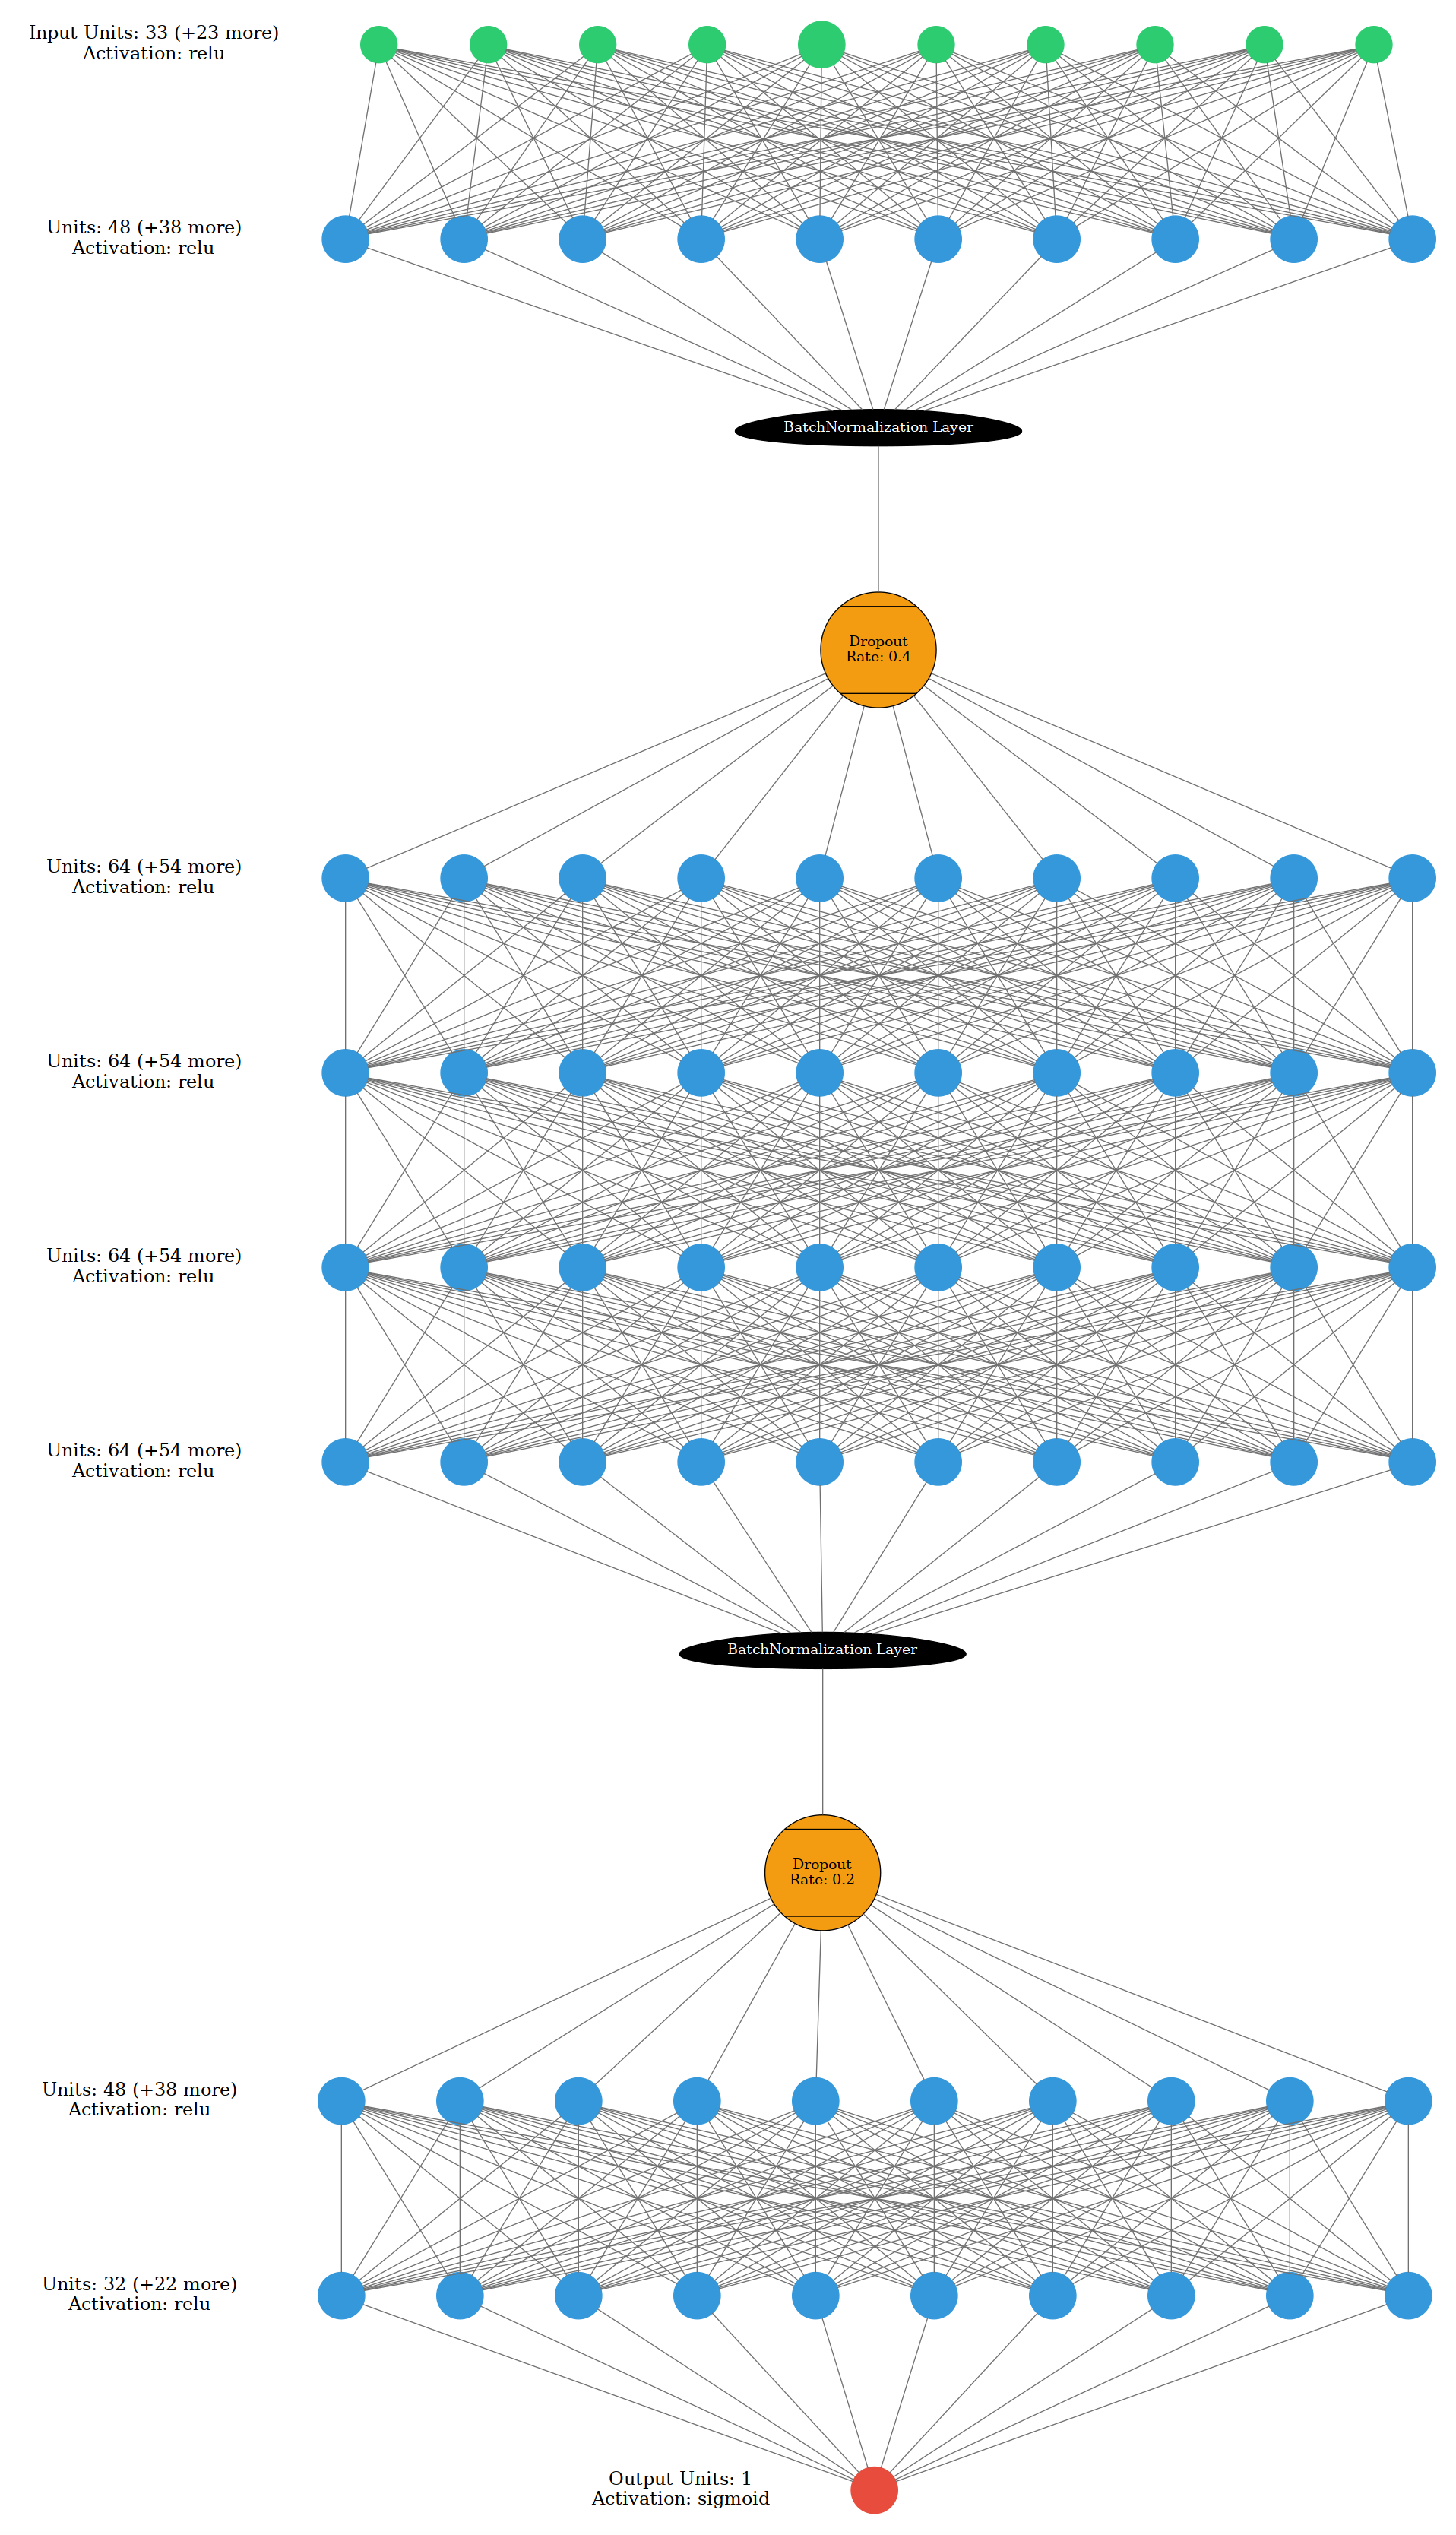

In [8]:
settings = {
    # ALL LAYERS
    'MAX_NEURONS': 10,
}

from keras_visualizer import visualizer
from keras import models, layers

visualizer(model, file_format='png', settings=settings, view=True)

from IPython.display import Image
Image(filename='graph.png')

# Train the model

In [9]:
from sklearn.utils import class_weight

from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping criteria
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Calculate class weights
#class_weights = {0: 1.0, 1: 0.08} 
class_weights = {0: 1.0, 1: 0.06} 

history = model.fit(
    X_train,
    Y_train,
    batch_size=512,
    epochs=12,
    validation_data=(X_test, Y_test),  # Provide validation data
    class_weight=class_weights,  # Apply class weights here
    callbacks=[early_stopping]  # Add early stopping callback
)

Epoch 1/12


2025-04-25 18:41:42.066104: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2025-04-25 18:41:43.777798: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fc308f78110 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-04-25 18:41:43.777815: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Ti, Compute Capability 8.9
2025-04-25 18:41:43.782404: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-04-25 18:41:43.795606: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1745599303.862118 1564989 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


938/938 [==============================] - 9s 6ms/step - loss: 3.8685 - precision: 0.8431 - recall: 0.3916 - auc: 0.8030 - val_loss: 4.0346 - val_precision: 0.9947 - val_recall: 0.5126 - val_auc: 0.9476
Epoch 2/12
938/938 [==============================] - 4s 5ms/step - loss: 3.4204 - precision: 0.9888 - recall: 0.4751 - auc: 0.9260 - val_loss: 3.6853 - val_precision: 0.9992 - val_recall: 0.5886 - val_auc: 0.9574
Epoch 3/12
938/938 [==============================] - 4s 5ms/step - loss: 3.0501 - precision: 0.9963 - recall: 0.5756 - auc: 0.9423 - val_loss: 3.3383 - val_precision: 0.9994 - val_recall: 0.6508 - val_auc: 0.9624
Epoch 4/12
938/938 [==============================] - 6s 6ms/step - loss: 2.7081 - precision: 0.9975 - recall: 0.6440 - auc: 0.9481 - val_loss: 2.9987 - val_precision: 0.9993 - val_recall: 0.6967 - val_auc: 0.9675
Epoch 5/12
938/938 [==============================] - 6s 6ms/step - loss: 2.3898 - precision: 0.9979 - recall: 0.6902 - auc: 0.9517 - val_loss: 2.6782 - va

# Save the model

In [10]:
model.save('models/decision_nn_model.keras')

# Display training results

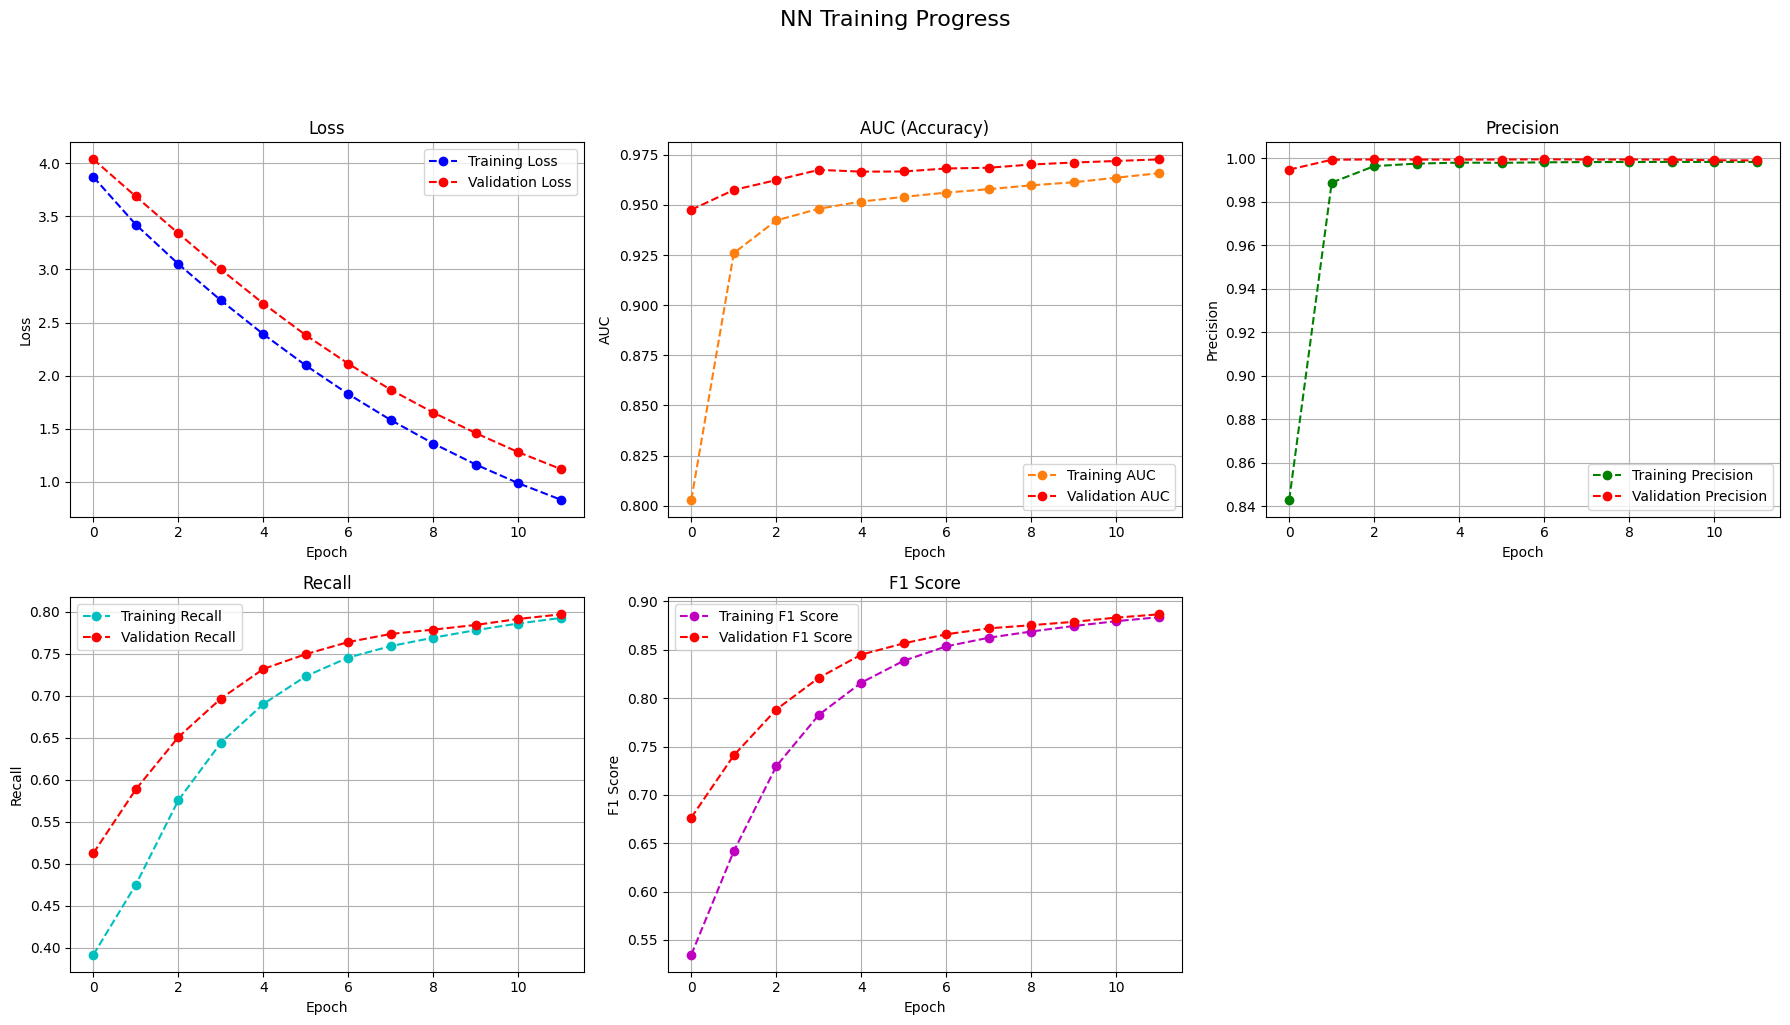

In [11]:
def get_metric(history, metric_name):
    if metric_name in history.history:
        return history.history[metric_name]
    elif f"{metric_name}_1" in history.history:
        return history.history[f"{metric_name}_1"]
    elif f"{metric_name}_2" in history.history:
        return history.history[f"{metric_name}_2"]
    else:
        raise KeyError(f"Metric {metric_name} not found in history.")

epoch_losses = get_metric(history, 'loss')
epoch_val_losses = get_metric(history, 'val_loss')
epoch_accuracies = get_metric(history, 'auc')
epoch_val_accuracies = get_metric(history, 'val_auc')
epoch_precisions = get_metric(history, 'precision')
epoch_val_precisions = get_metric(history, 'val_precision')
epoch_recalls = get_metric(history, 'recall')
epoch_val_recalls = get_metric(history, 'val_recall')

# Calculate F1 score with epsilon to avoid division by zero
epsilon = 1e-10  # small value to prevent division by zero
epoch_f1s = [2 * (p * r) / (p + r + epsilon) for p, r in zip(epoch_precisions, epoch_recalls)]
epoch_val_f1s = [2 * (p * r) / (p + r + epsilon) for p, r in zip(epoch_val_precisions, epoch_val_recalls)]

import matplotlib.pyplot as plt

plt.figure(figsize=(18, 10))

# Plot for Loss
plt.subplot(2, 3, 1)
plt.plot(epoch_losses, linestyle='--', marker='o', color='b', label='Training Loss')
plt.plot(epoch_val_losses, linestyle='--', marker='o', color='r', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.grid(True)

# Plot for AUC (as a proxy for Accuracy)
plt.subplot(2, 3, 2)
plt.plot(epoch_accuracies, linestyle='--', marker='o', color='#ff7f0e', label='Training AUC')
plt.plot(epoch_val_accuracies, linestyle='--', marker='o', color='r', label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('AUC (Accuracy)')
plt.legend()
plt.grid(True)

# Plot for Precision
plt.subplot(2, 3, 3)
plt.plot(epoch_precisions, linestyle='--', marker='o', color='g', label='Training Precision')
plt.plot(epoch_val_precisions, linestyle='--', marker='o', color='r', label='Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision')
plt.legend()
plt.grid(True)

# Plot for Recall
plt.subplot(2, 3, 4)
plt.plot(epoch_recalls, linestyle='--', marker='o', color='c', label='Training Recall')
plt.plot(epoch_val_recalls, linestyle='--', marker='o', color='r', label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Recall')
plt.legend()
plt.grid(True)

# Plot for F1 Score
plt.subplot(2, 3, 5)
plt.plot(epoch_f1s, linestyle='--', marker='o', color='m', label='Training F1 Score')
plt.plot(epoch_val_f1s, linestyle='--', marker='o', color='r', label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score')
plt.legend()
plt.grid(True)

plt.suptitle('NN Training Progress', fontsize=16, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save the figure
plt.savefig('nn_training_progress.png', dpi=500, bbox_inches='tight', pad_inches=0.5)
plt.show()


# Evaluate the model

3750/3750 [==============================] - 6s 2ms/step - loss: 1.1217 - precision: 0.9989 - recall: 0.7970 - auc: 0.9727
Loss =  1.1217397451400757
Accuracy =  0.9989346861839294
3750/3750 [==============================] - 4s 990us/step

=== RESULTS ===
              precision    recall  f1-score   support

      Benign     0.8311    0.9991    0.9074     60000
   Malicious     0.9989    0.7970    0.8866     60000

    accuracy                         0.8981    120000
   macro avg     0.9150    0.8981    0.8970    120000
weighted avg     0.9150    0.8981    0.8970    120000

False Positive Rate = 0.00085

Confusion Matrix:
[[59949    51]
 [12179 47821]]


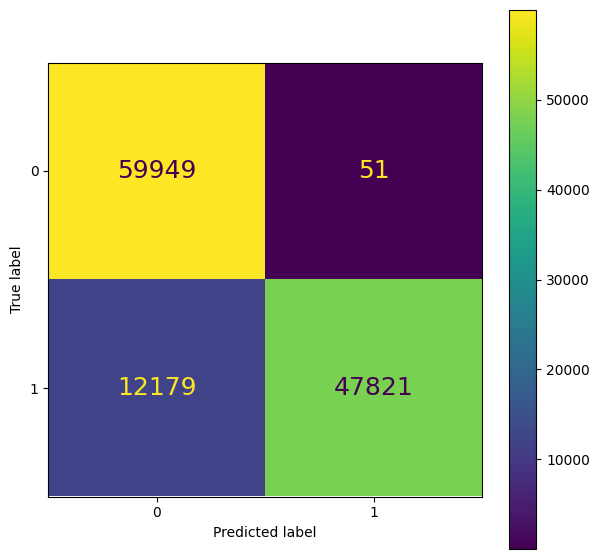

In [12]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Evaluate the model
loss_and_metrics = model.evaluate(X_test, Y_test)
print('Loss = ', loss_and_metrics[0])
print('Accuracy = ', loss_and_metrics[1])

# Generate predictions
Y_pred = model.predict(X_test)
Y_pred = np.round(Y_pred).astype(int)  # Convert probabilities to binary predictions

# Calculate additional metrics
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)

# Confusion matrix
cm = confusion_matrix(Y_test, Y_pred)

# False Positive Rate
tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn)

# Display the metrics
print('\n=== RESULTS ===')
print(classification_report(Y_test, Y_pred, target_names=['Benign', 'Malicious'], digits=4))
print('False Positive Rate =', fpr)


# Display the confusion matrix
print('\nConfusion Matrix:')
print(cm)

# Optionally, plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(7, 7))  # Increase figure size for better readability
disp.plot(ax=ax, values_format='d')
for labels in disp.text_:
    for label in labels:
        label.set_fontsize(18) 
plt.show()

In [13]:
print("Initial predictions (before training):", model.predict(X_test[:20]))

Y_pred = model.predict(X_test)
Y_pred = np.round(Y_pred).astype(int)
print("Final Predictions:", np.unique(Y_pred, return_counts=True))





1/1 [==============================] - 0s 83ms/step
Initial predictions (before training): [[0.00662176]
 [0.66475886]
 [0.00543806]
 [0.8766582 ]
 [0.00654065]
 [0.00930517]
 [0.00729508]
 [0.00774438]
 [0.8764149 ]
 [0.8096697 ]
 [0.8040982 ]
 [0.7544687 ]
 [0.5859163 ]
 [0.00716341]
 [0.00635081]
 [0.00989968]
 [0.00619503]
 [0.00950946]
 [0.00569957]
 [0.00656664]]
3750/3750 [==============================] - 4s 1ms/step
Final Predictions: (array([0, 1]), array([72128, 47872]))


In [14]:
import numpy as np
import pandas as pd

# Generate predictions (probabilities)
Y_prob = model.predict(X_test)  # Get probability scores

# Convert probabilities to binary predictions
Y_pred = np.round(Y_prob).astype(int)

# Convert Y_test to a NumPy array before flattening
Y_test_array = Y_test.to_numpy().flatten()

# Create a DataFrame to display probabilities along with actual and predicted labels
results_df = pd.DataFrame({
    'Actual Label': Y_test_array,
    'Predicted Label': Y_pred.flatten(),
    'Predicted Probability': Y_prob.flatten()
})

# Display the results using Pandas
print(results_df.head(50))  # Display first few rows

# Optionally, save the results to a CSV file for further analysis
#results_df.to_csv("test_set_predictions.csv", index=False)


3750/3750 [==============================] - 4s 979us/step
    Actual Label  Predicted Label  Predicted Probability
0              0                0               0.006622
1              1                1               0.664759
2              0                0               0.005438
3              1                1               0.876658
4              0                0               0.006541
5              0                0               0.009305
6              0                0               0.007295
7              0                0               0.007744
8              1                1               0.876415
9              1                1               0.809670
10             1                1               0.804098
11             1                1               0.754469
12             1                1               0.585916
13             0                0               0.007163
14             0                0               0.006351
15             0             

# Feature Importance Analysis

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
Permutation explainer: 1001it [00:57, 14.81it/s]                                                                                                                                              
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


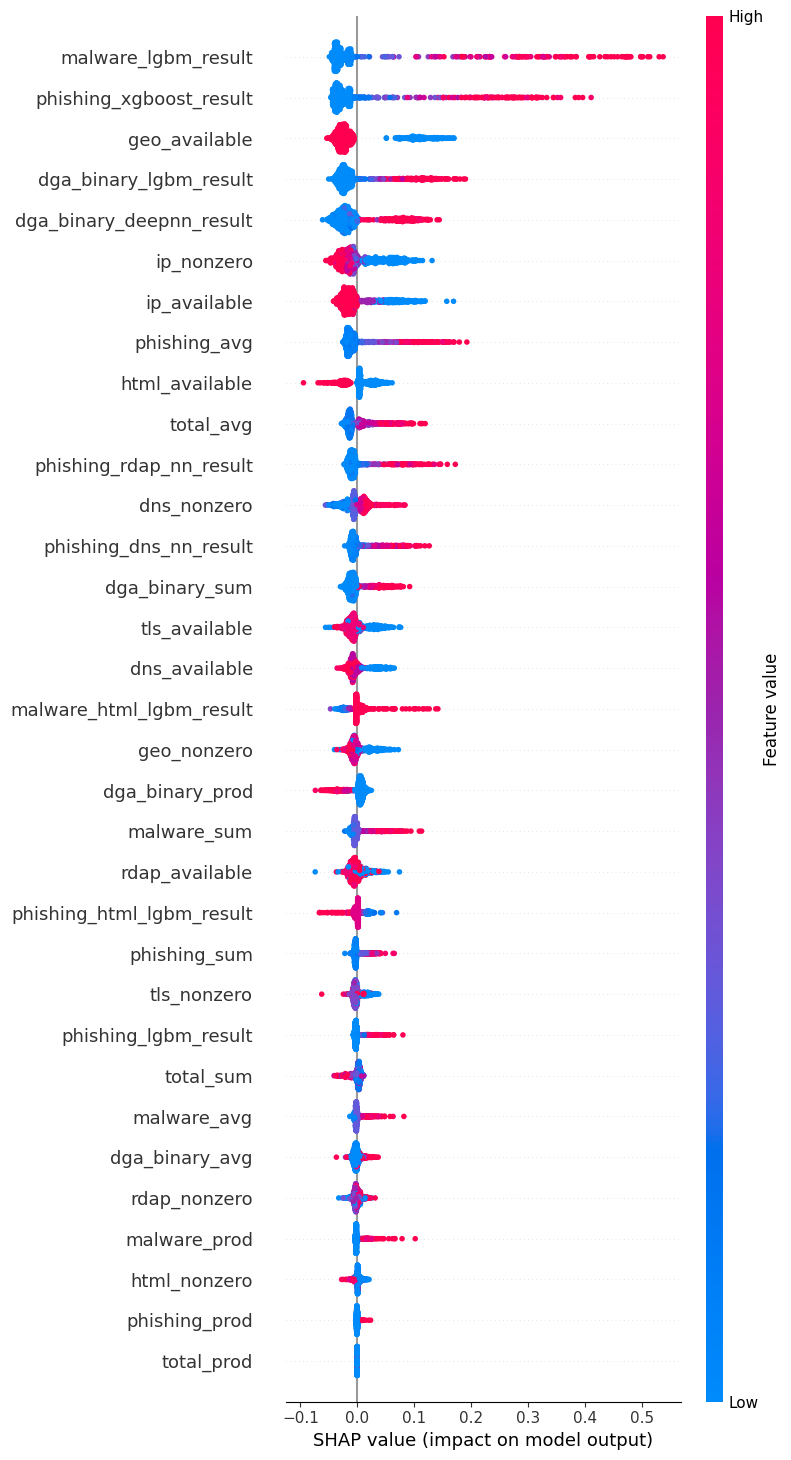

In [15]:
import shap

# Ensure that X_train and X_test are DataFrames with the correct column names
# You can set the column names from the 'features' DataFrame like this:
X_train.columns = features.columns
X_test.columns = features.columns

n_samples = 1000

# Convert your training set to a NumPy format if it's not already
background = X_train[:n_samples].to_numpy()

# Use the generic SHAP Explainer interface
explainer = shap.Explainer(model, background)

# Generate SHAP values for the test set
shap_values = explainer(X_test[:n_samples].to_numpy())

# Plotting the summary plot for feature importance
# Use the column names from the 'features' DataFrame as the feature names
shap.summary_plot(shap_values.values, X_test[:n_samples], feature_names=features.columns, max_display=45)


# Test the model on a separate testing dataset

In [22]:
import pandas as pd
import joblib
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score

# Load the trained model and scaler
model = load_model('models/decision_nn_model.keras')
scaler = joblib.load('boundaries/decision_nn_scaler.joblib')

# Load the parquet file
df = pd.read_parquet('data/ver_preliminary.parquet')


#df["total_avg"] = 0;


# Separate features and labels
X = df.drop(columns=['label', 'domain_name'])
y = df['label']

# Apply the scaler
X_scaled = scaler.transform(X)

# Predict probabilities
probabilities = model.predict(X_scaled)

# Predict classes from probabilities (assuming binary classification)
predictions = (probabilities > 0.5).astype(int).flatten()

# Calculate accuracy
accuracy = accuracy_score(y, predictions)

# Display results
print("Predicted Probabilities:\n", probabilities)
print("\nAccuracy:", accuracy)


7/7 [==============================] - 0s 1ms/step
Predicted Probabilities:
 [[0.89691716]
 [0.00573959]
 [0.00632969]
 [0.8737013 ]
 [0.00652031]
 [0.74897575]
 [0.01703418]
 [0.00614544]
 [0.7703254 ]
 [0.91116357]
 [0.7703066 ]
 [0.01058672]
 [0.04758617]
 [0.00625098]
 [0.86584073]
 [0.00706996]
 [0.01445379]
 [0.8785371 ]
 [0.00737895]
 [0.01017173]
 [0.00696225]
 [0.7696959 ]
 [0.58312714]
 [0.00552982]
 [0.77064764]
 [0.7704005 ]
 [0.00824206]
 [0.01067249]
 [0.0090559 ]
 [0.7676431 ]
 [0.01419322]
 [0.01376124]
 [0.00603949]
 [0.01061247]
 [0.00705241]
 [0.00680321]
 [0.741246  ]
 [0.83635485]
 [0.00744024]
 [0.6899305 ]
 [0.04396949]
 [0.6198264 ]
 [0.7062032 ]
 [0.00619754]
 [0.01943545]
 [0.7701087 ]
 [0.77037126]
 [0.0077464 ]
 [0.7703254 ]
 [0.8724345 ]
 [0.75691575]
 [0.00623995]
 [0.05655611]
 [0.75721174]
 [0.01058672]
 [0.77002376]
 [0.00806667]
 [0.76922315]
 [0.884432  ]
 [0.00542446]
 [0.01029013]
 [0.00607854]
 [0.59618354]
 [0.01058672]
 [0.01065418]
 [0.0073211 ]

## Examine missclassified domains

97/97 [==============================] - 0s 977us/step

Misclassified domain: signin.online.drive.kommunikationscheck.de
True label: phishing, Predicted: 0, Prob: 0.0106


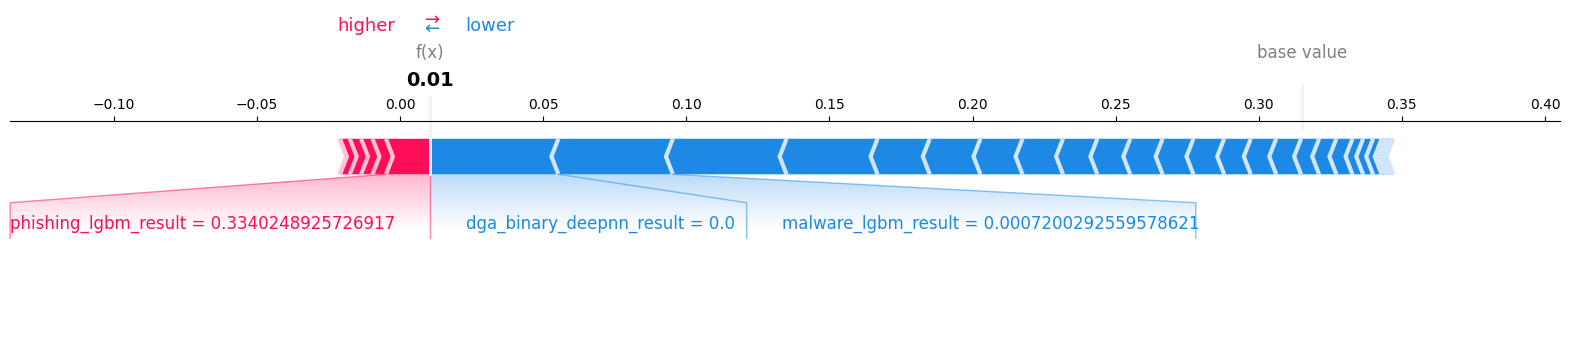


Misclassified domain: fourseasonspoaclassifieds.com
True label: benign, Predicted: 0, Prob: 0.4050


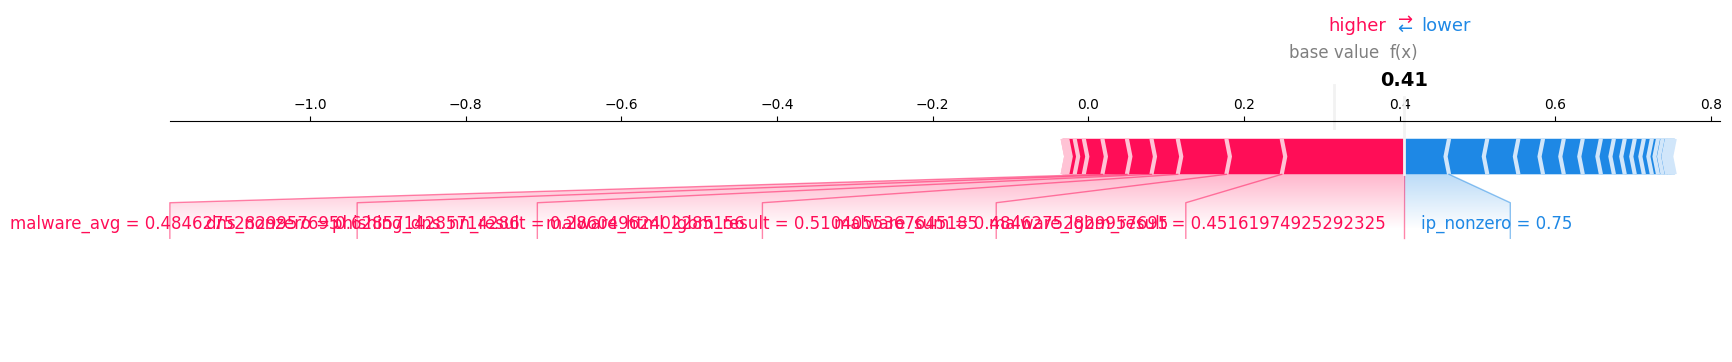


Misclassified domain: pecl.php.net
True label: benign, Predicted: 0, Prob: 0.0074


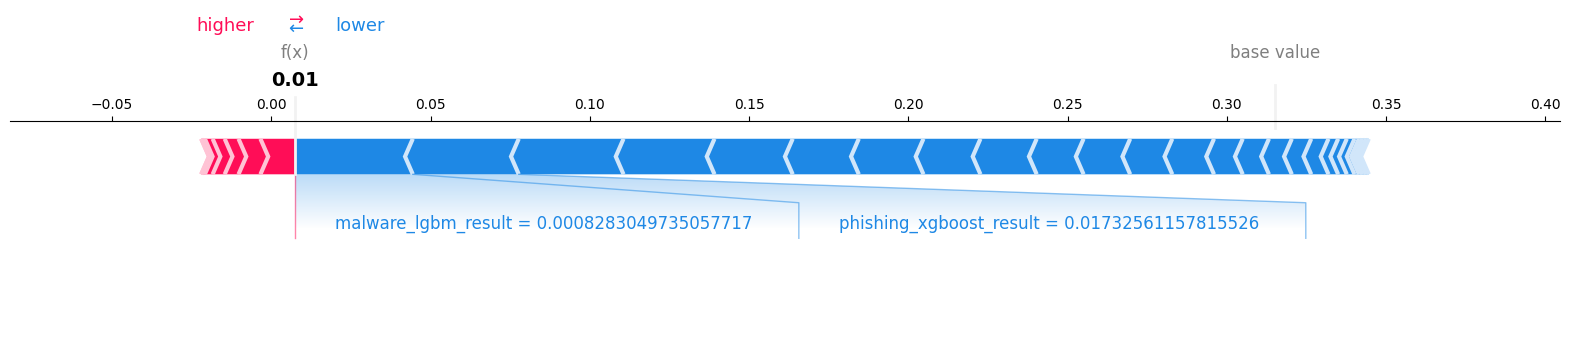


Misclassified domain: 123-8xj.pages.dev
True label: phishing, Predicted: 1, Prob: 0.7062


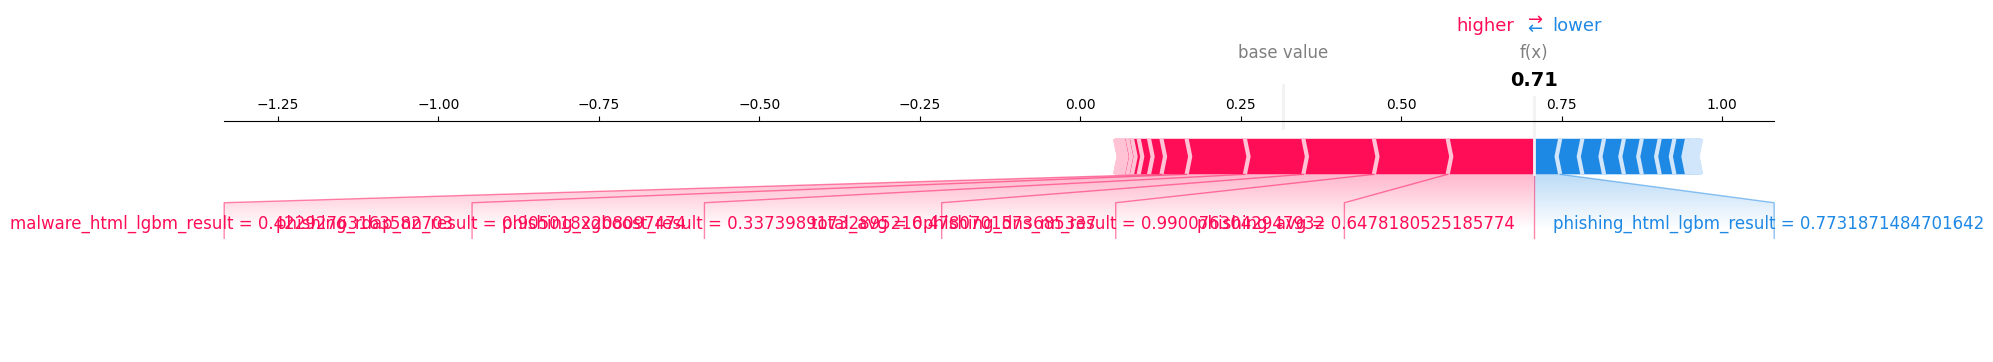


Misclassified domain: haeyfneelctkmqmsrwoekw.tj
True label: dga, Predicted: 1, Prob: 0.7700


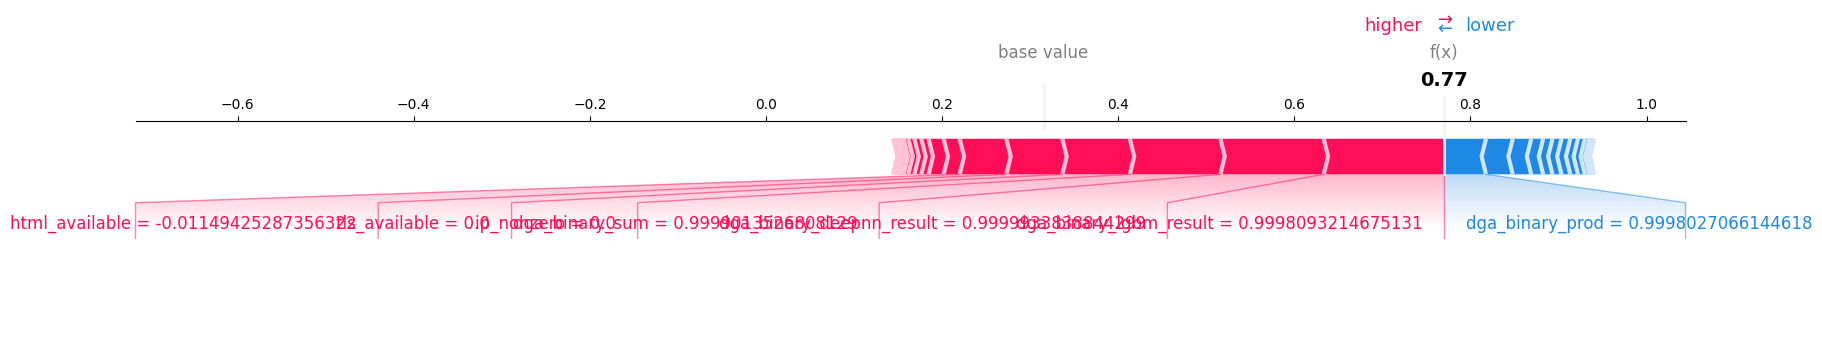

In [23]:
import shap
import numpy as np
import random
import matplotlib.pyplot as plt

# Ensure scaled input has feature names
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

# Identify misclassified samples
misclassified_indices = np.where(predictions != y.values)[0]

if len(misclassified_indices) == 0:
    print("No misclassified samples found.")
else:
    # Pick up to 5 misclassified samples
    selected_indices = random.sample(list(misclassified_indices), min(5, len(misclassified_indices)))

    # Background dataset (small sample for SHAP)
    background = X_scaled_df.sample(n=100, random_state=42)

    # Wrap model to convert DataFrame to array
    model_fn = lambda x: model.predict(x.values if isinstance(x, pd.DataFrame) else x)

    # SHAP Explainer with correct model signature
    explainer = shap.Explainer(model_fn, background)

    # Compute SHAP values
    shap_values = explainer(X_scaled_df.iloc[selected_indices])

    # Display force plots
    for i, idx in enumerate(selected_indices):
        print(f"\nMisclassified domain: {df.iloc[idx]['domain_name']}")
        print(f"True label: {y.iloc[idx]}, Predicted: {predictions[idx]}, Prob: {probabilities[idx][0]:.4f}")
        shap.plots.force(shap_values[i], matplotlib=True)
        plt.show()


## Compare training and additional validation datasets

Training feature count: 33
New data feature count: 33

Features only in training set: set()
Features only in new set: set()


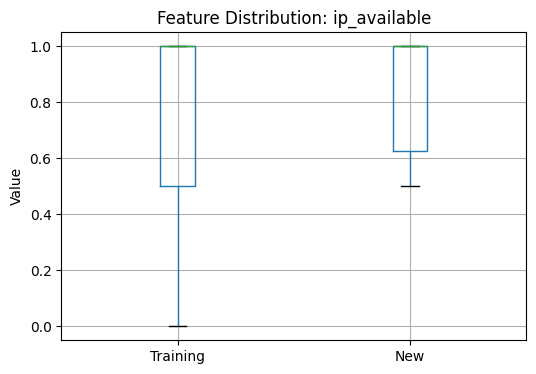

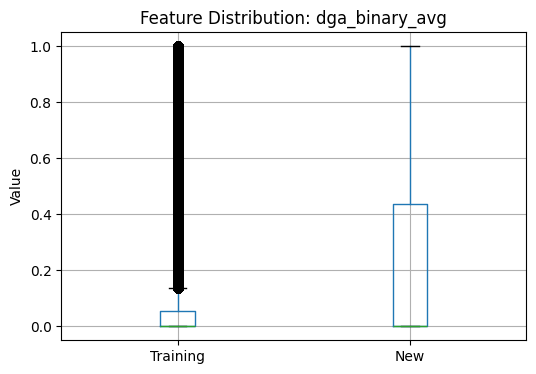

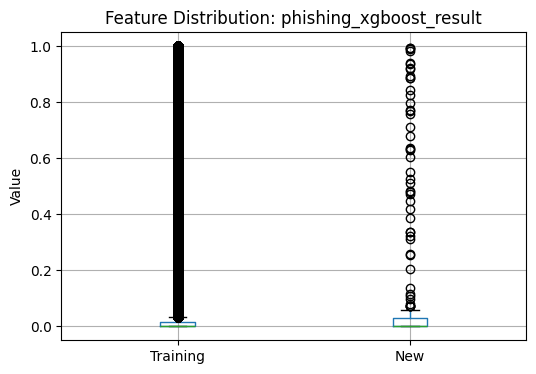

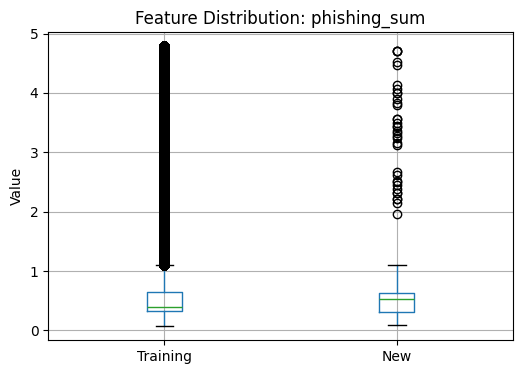

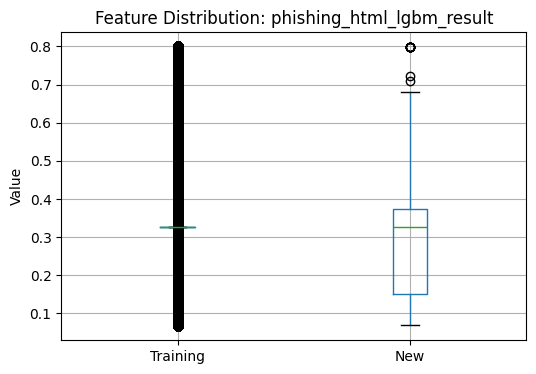

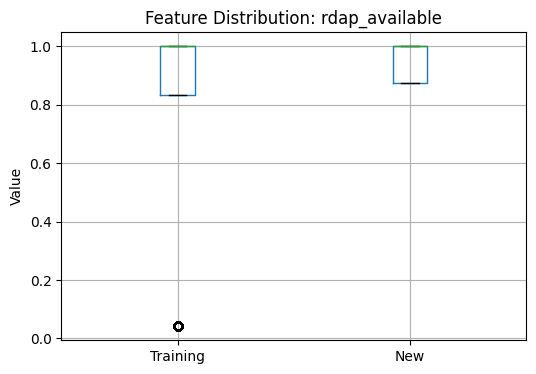

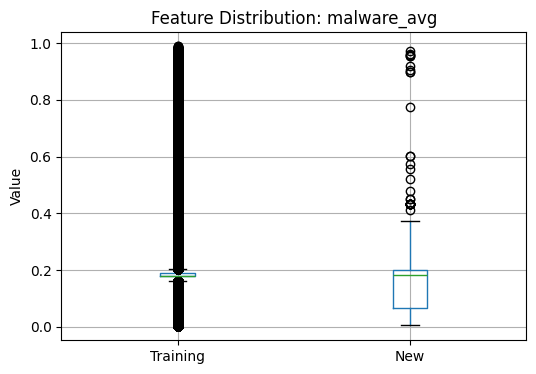

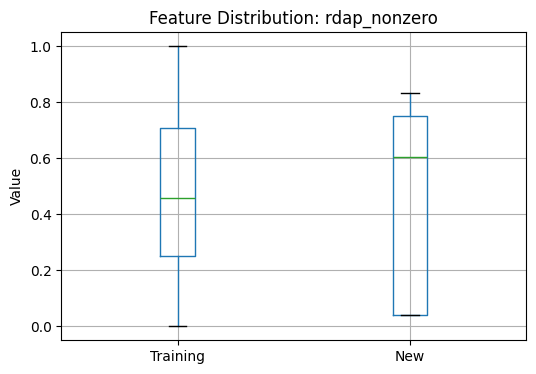

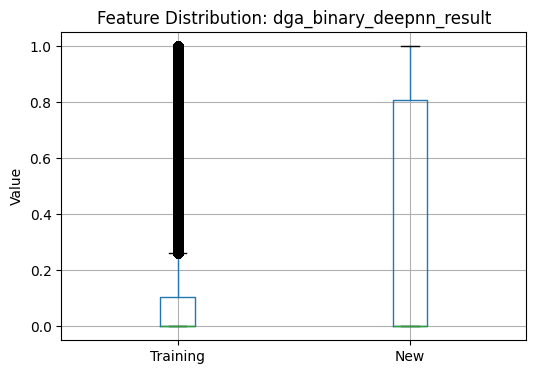

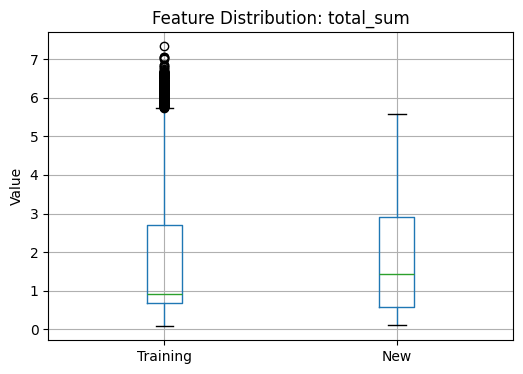

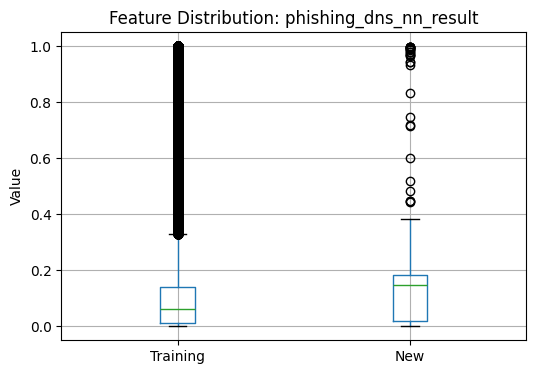

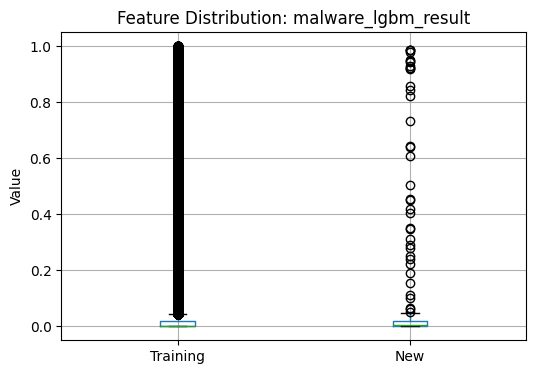

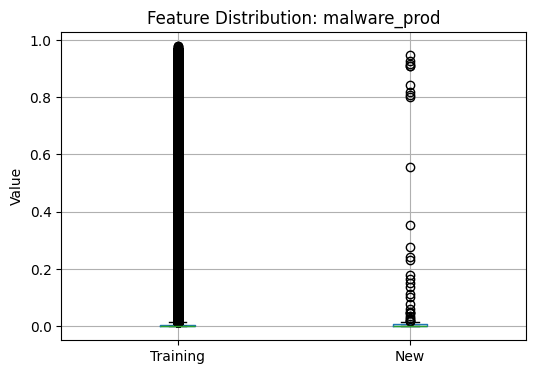

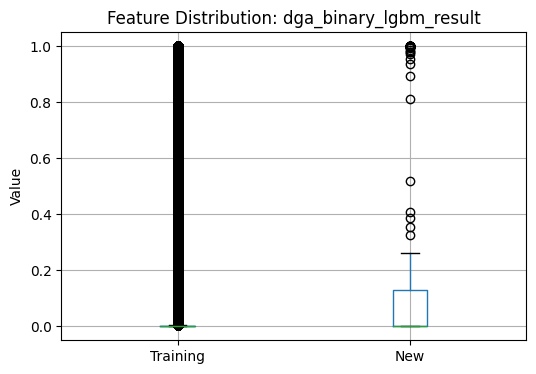

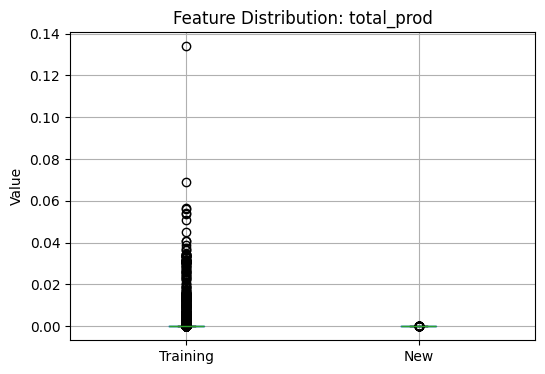

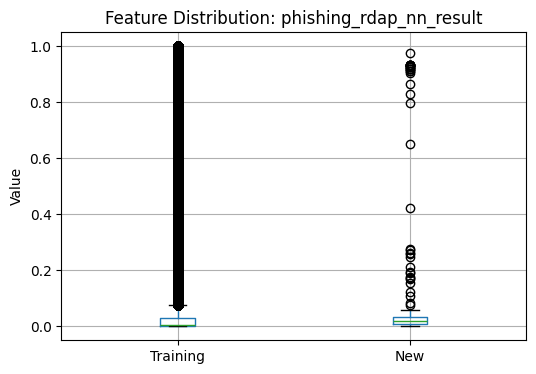

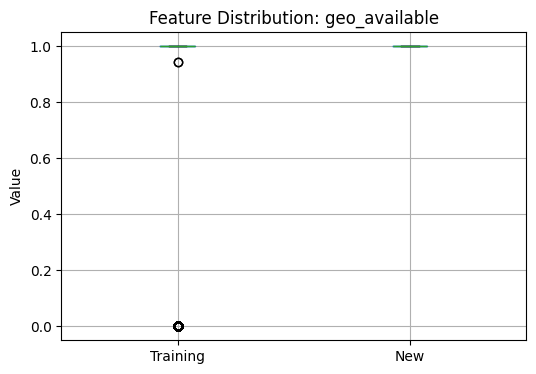

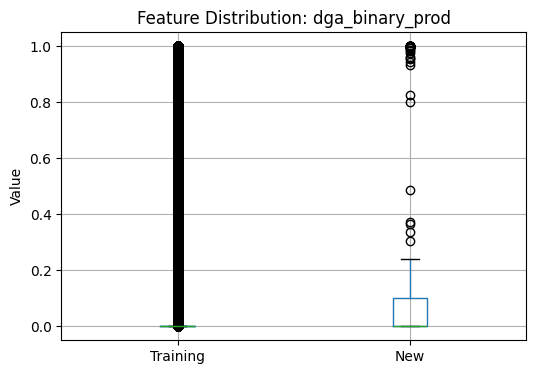

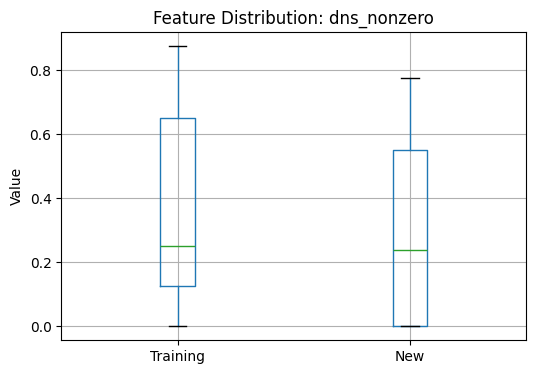

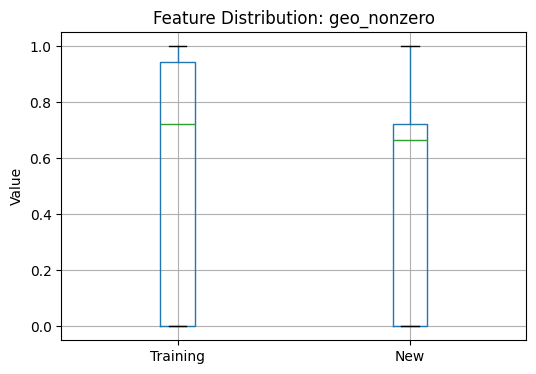

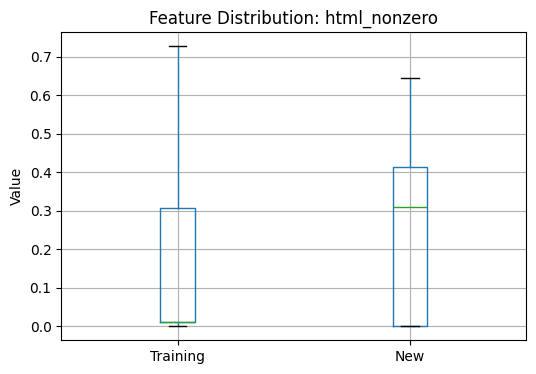

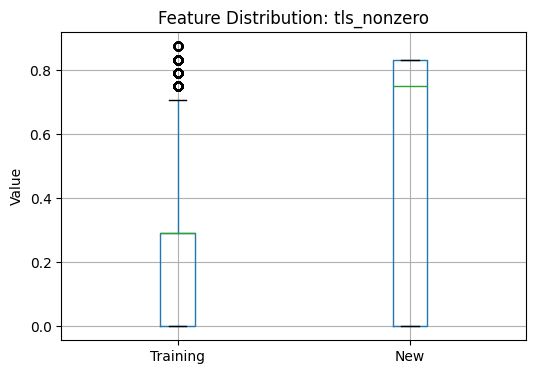

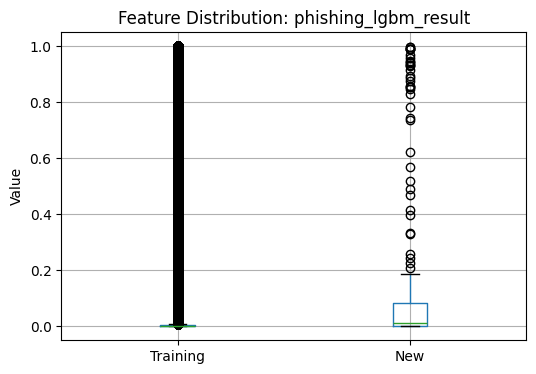

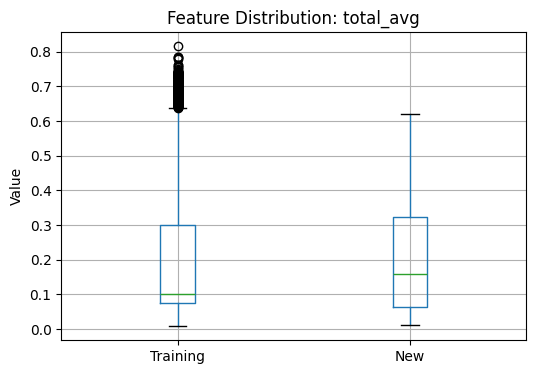

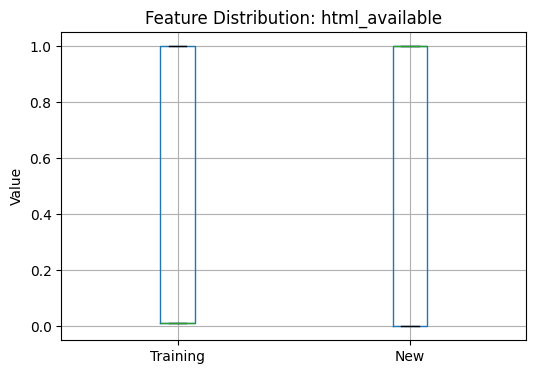

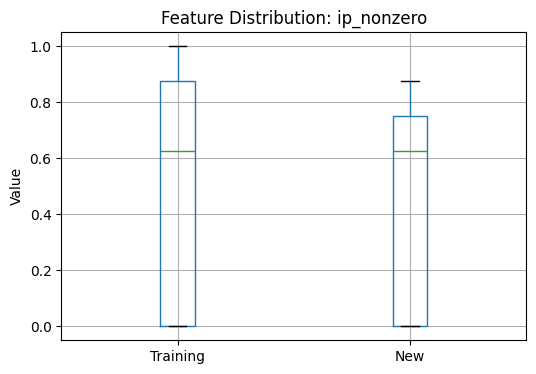

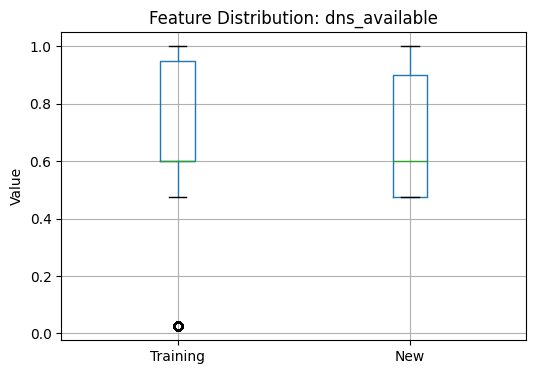

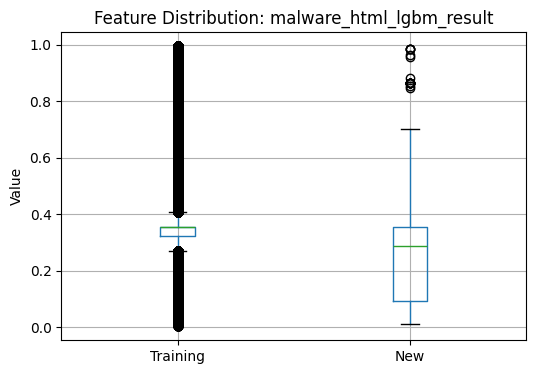

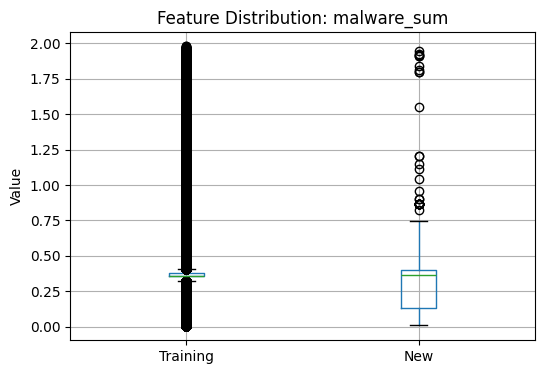

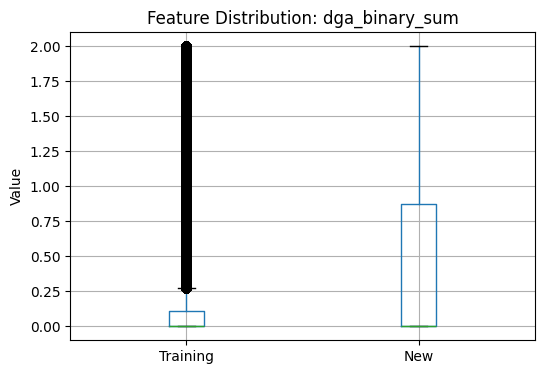

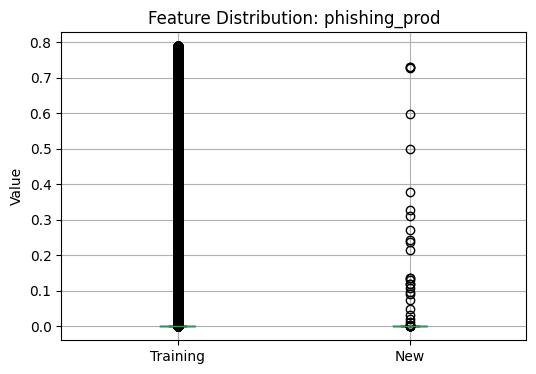

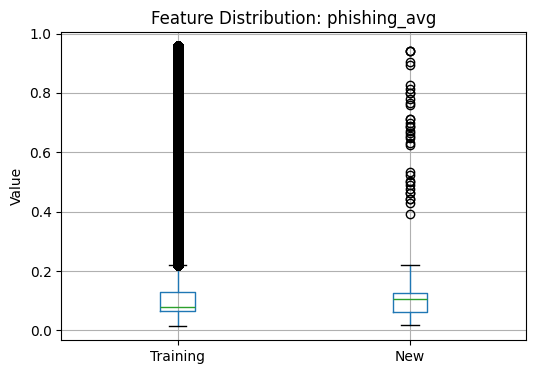

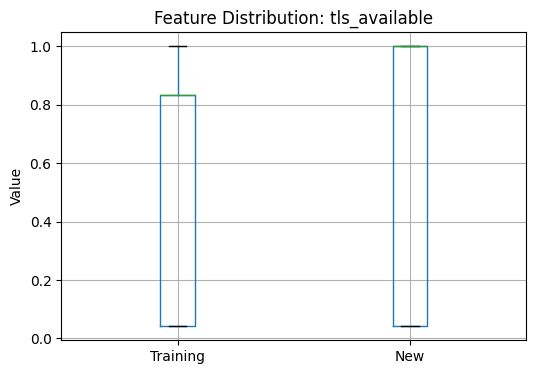

In [28]:
import pandas as pd
import matplotlib.pyplot as plt

# Load training and new datasets
df_train = pd.read_parquet('data/preliminary_results_2504.parquet')  # <-- Update this path!
df_new = pd.read_parquet('data/ver_preliminary.parquet')

# Drop non-feature columns
df_train_features = df_train.drop(columns=['label', 'domain_name'], errors='ignore')
df_new_features = df_new.drop(columns=['label', 'domain_name'], errors='ignore')

# Compare feature names
train_features_set = set(df_train_features.columns)
new_features_set = set(df_new_features.columns)

print("Training feature count:", len(train_features_set))
print("New data feature count:", len(new_features_set))

print("\nFeatures only in training set:", train_features_set - new_features_set)
print("Features only in new set:", new_features_set - train_features_set)

# Find common features
common_features = list(train_features_set & new_features_set)

# Visualize feature distributions with boxplots
for feature in common_features:
    plt.figure(figsize=(6, 4))
    df_plot = pd.DataFrame({
        'Training': df_train_features[feature],
        'New': df_new_features[feature]
    })
    df_plot.boxplot()
    plt.title(f'Feature Distribution: {feature}')
    plt.ylabel('Value')
    plt.show()


In [29]:


import pandas as pd

# Load the datasets
train_df = pd.read_parquet('data/preliminary_results_2504.parquet')  # <-- Update this path!
ver_df = pd.read_parquet('data/ver_preliminary.parquet')

# Remove non-feature columns
non_feature_cols = ['label', 'domain_name']
train_features = train_df.drop(columns=non_feature_cols, errors='ignore')
ver_features = ver_df.drop(columns=non_feature_cols, errors='ignore')

# Get metadata
train_metadata = {
    "n_samples": train_df.shape[0],
    "n_features": train_features.shape[1],
    "feature_names": list(train_features.columns),
    "label_distribution": train_df['label'].value_counts(normalize=True)
}

ver_metadata = {
    "n_samples": ver_df.shape[0],
    "n_features": ver_features.shape[1],
    "feature_names": list(ver_features.columns),
    "label_distribution": ver_df['label'].value_counts(normalize=True)
}


(train_metadata, ver_metadata)

({'n_samples': 600000,
  'n_features': 33,
  'feature_names': ['dns_available',
   'dns_nonzero',
   'tls_available',
   'tls_nonzero',
   'ip_available',
   'ip_nonzero',
   'rdap_available',
   'rdap_nonzero',
   'geo_available',
   'geo_nonzero',
   'html_available',
   'html_nonzero',
   'phishing_lgbm_result',
   'phishing_xgboost_result',
   'phishing_dns_nn_result',
   'phishing_rdap_nn_result',
   'phishing_html_lgbm_result',
   'malware_lgbm_result',
   'malware_html_lgbm_result',
   'dga_binary_deepnn_result',
   'dga_binary_lgbm_result',
   'phishing_sum',
   'phishing_avg',
   'phishing_prod',
   'malware_sum',
   'malware_avg',
   'malware_prod',
   'dga_binary_sum',
   'dga_binary_avg',
   'dga_binary_prod',
   'total_sum',
   'total_avg',
   'total_prod'],
  'label_distribution': label
  benign      0.500000
  phishing    0.166667
  malware     0.166667
  dga         0.166667
  Name: proportion, dtype: float64},
 {'n_samples': 210,
  'n_features': 33,
  'feature_names': 

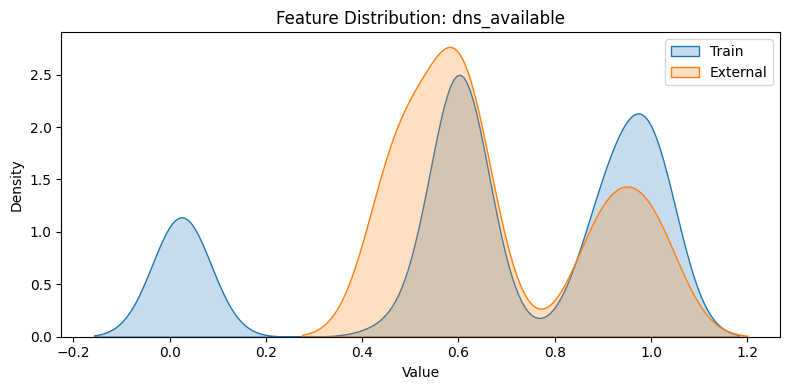

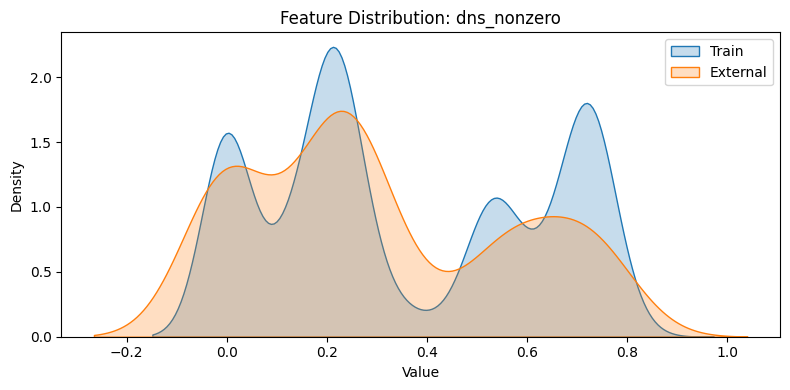

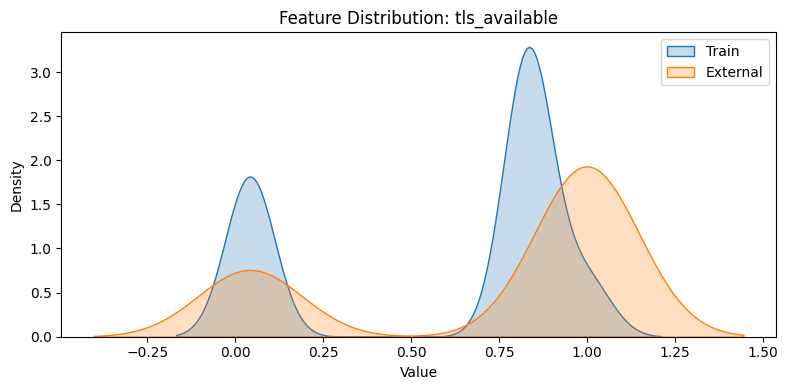

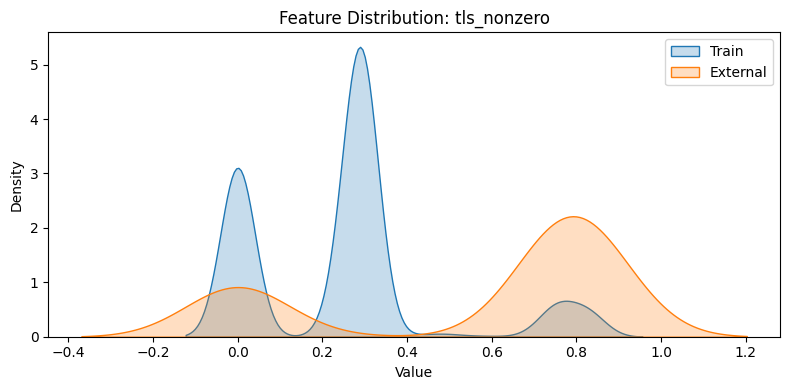

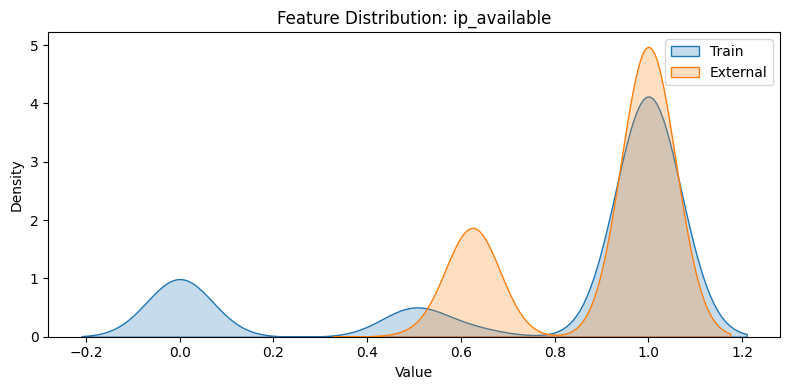

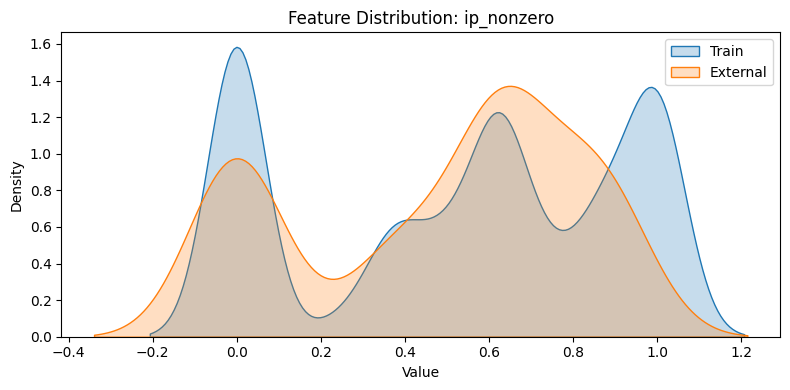

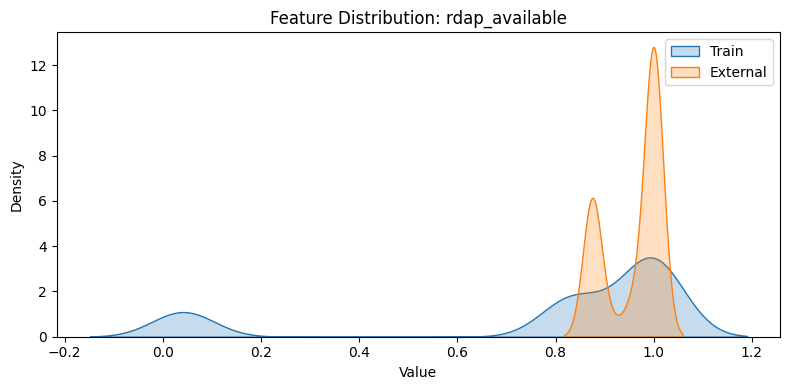

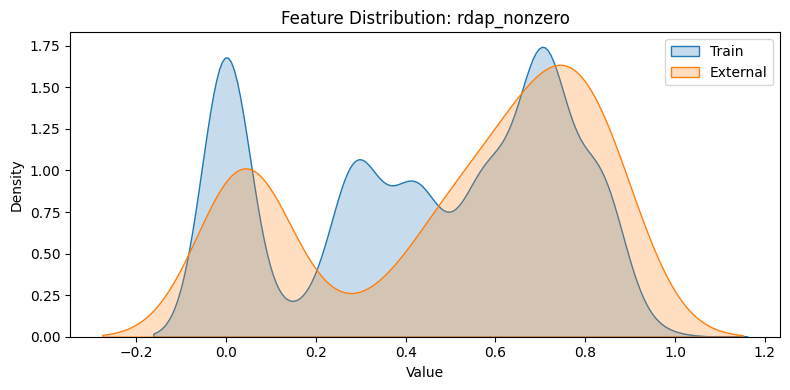

Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.


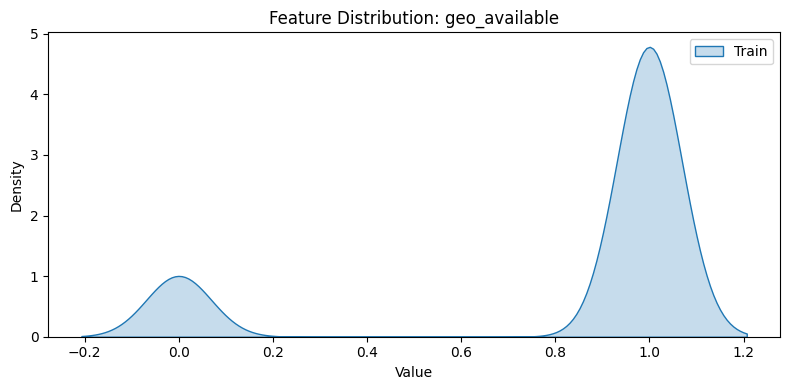

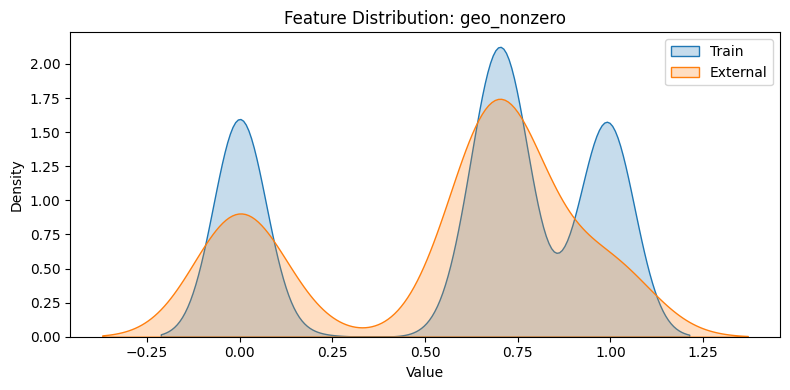

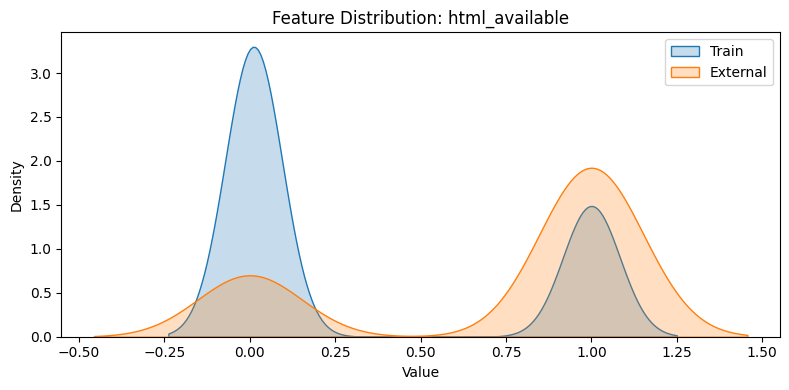

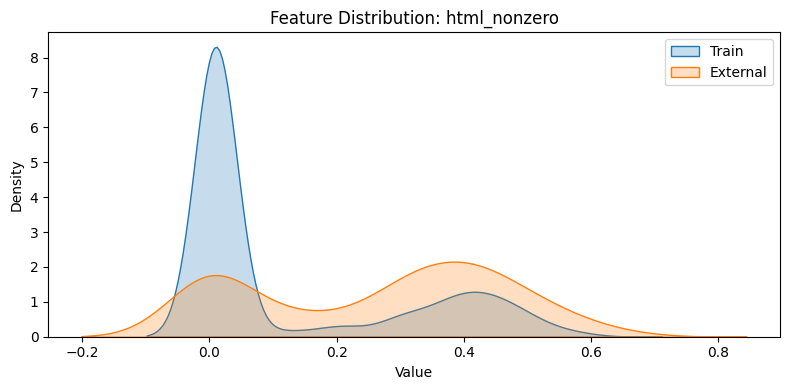

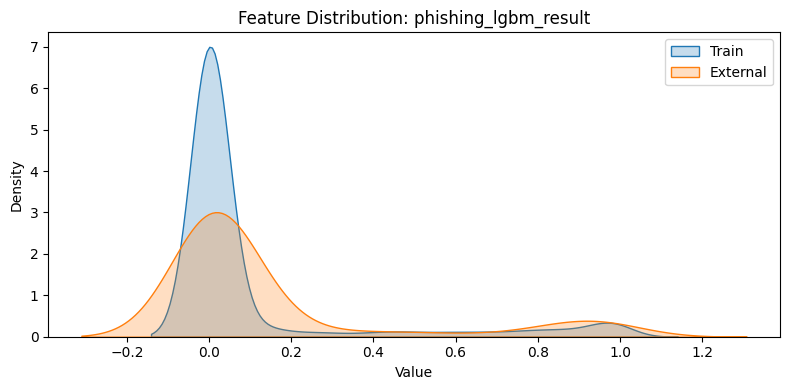

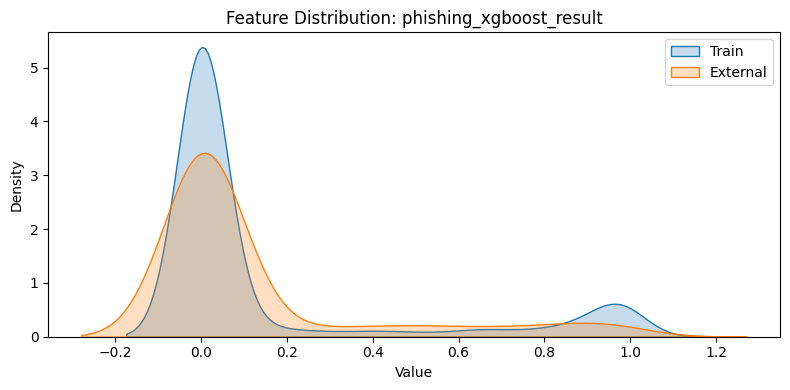

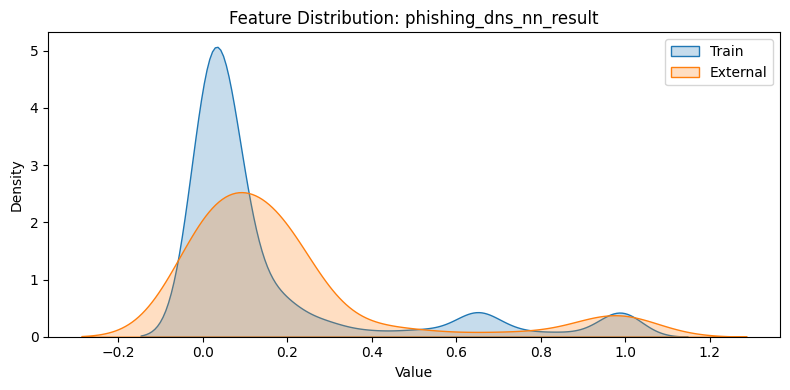

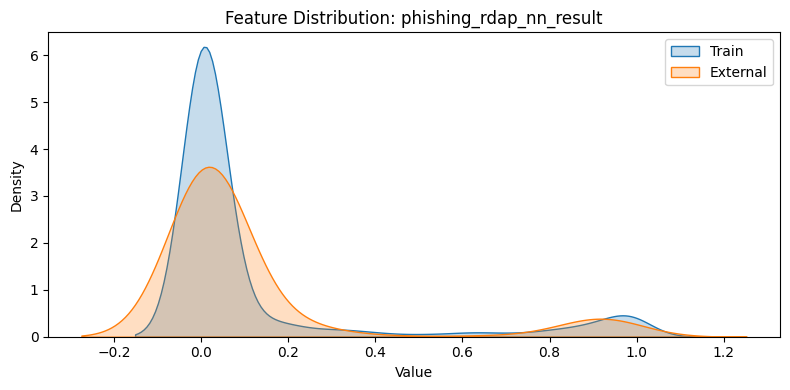

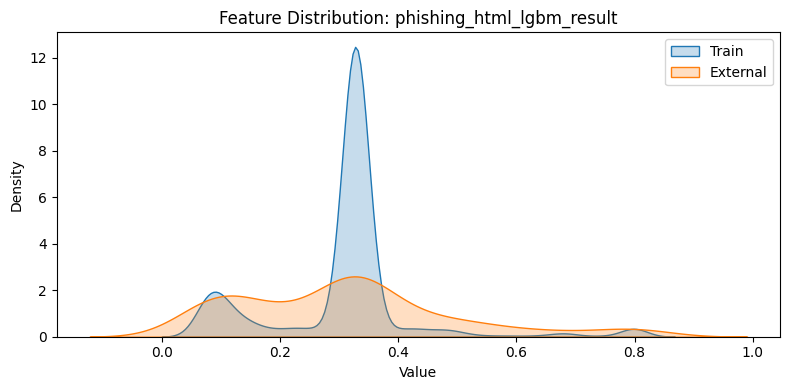

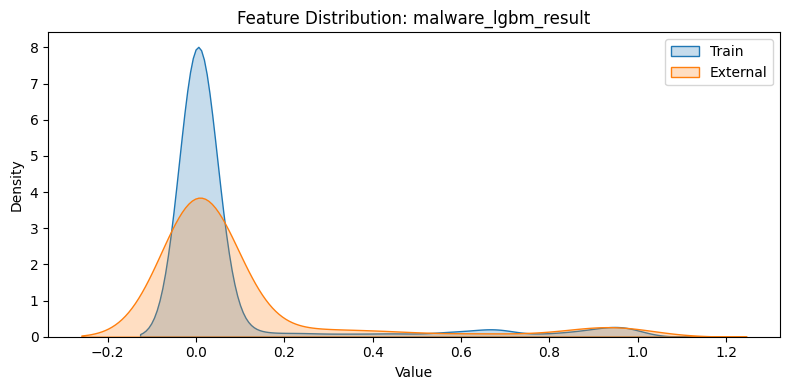

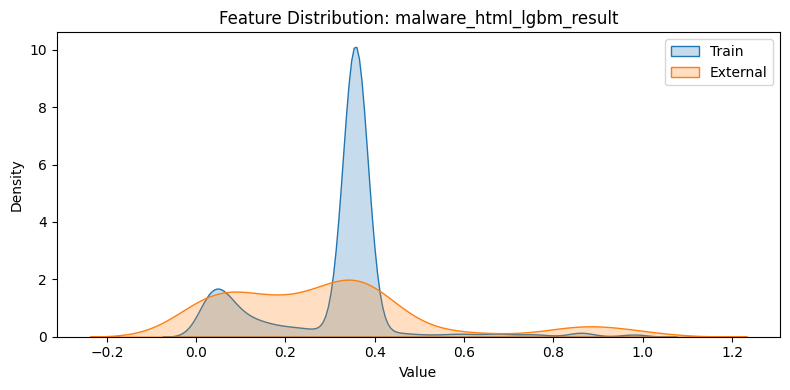

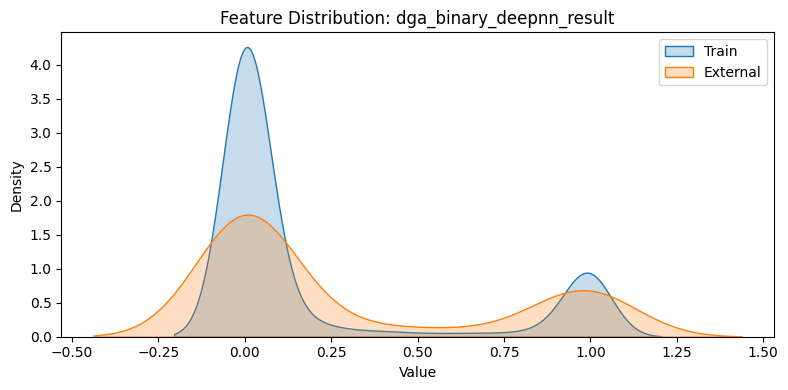

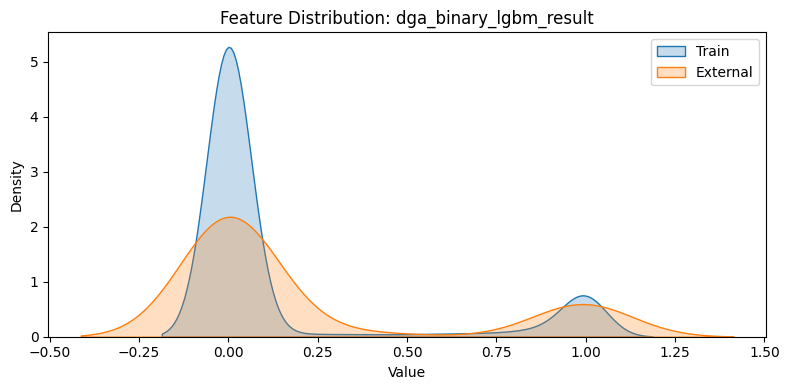

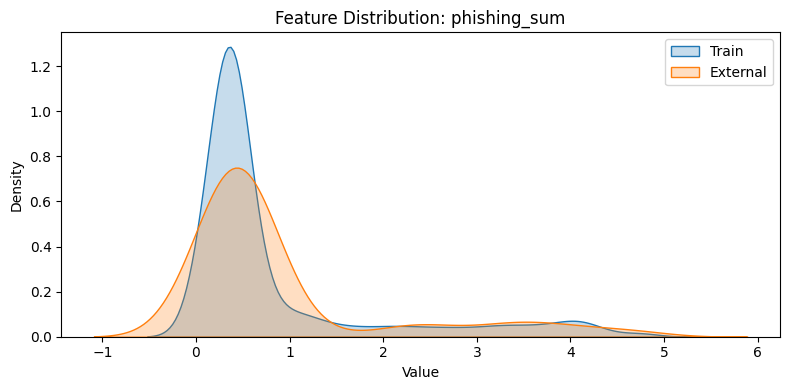

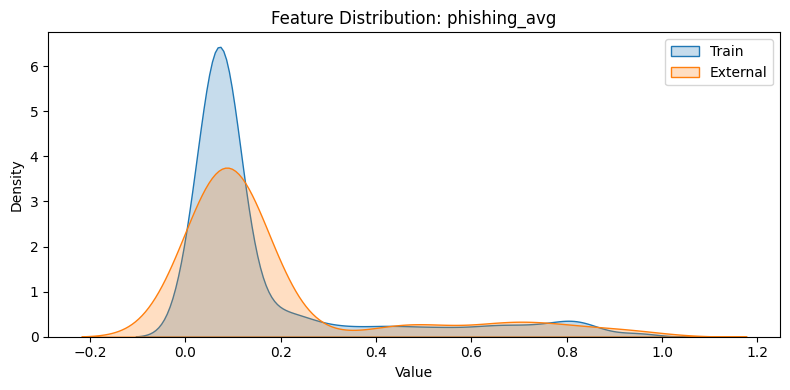

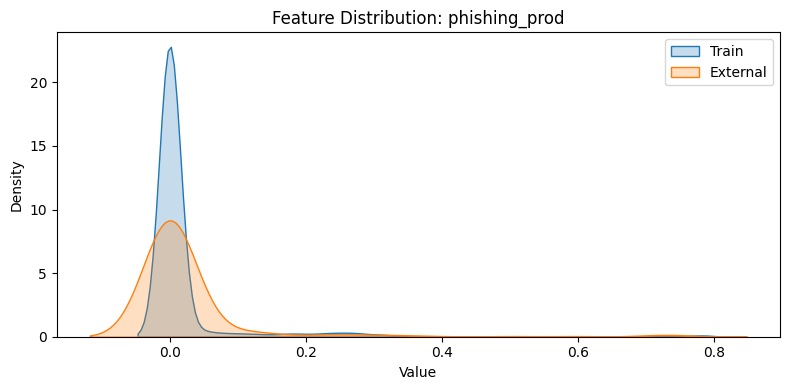

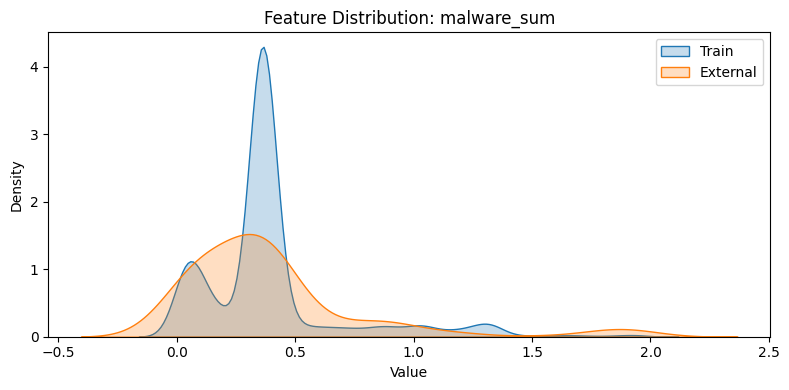

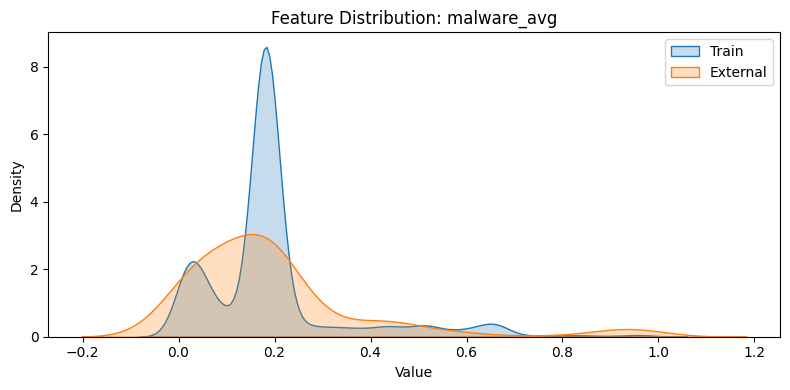

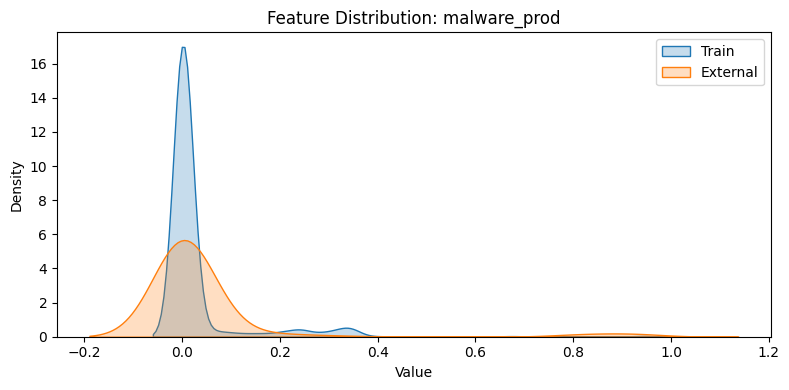

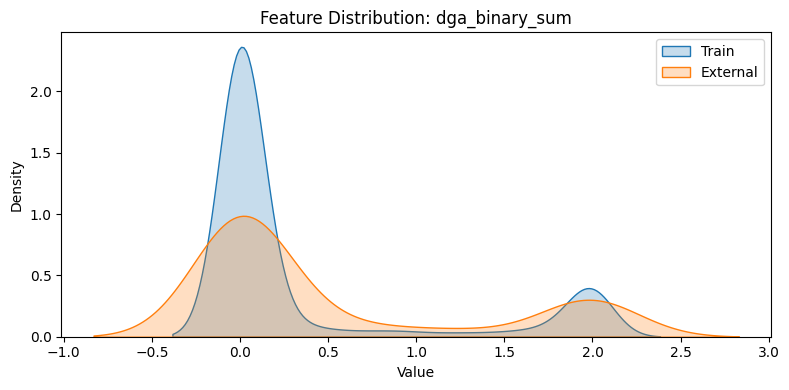

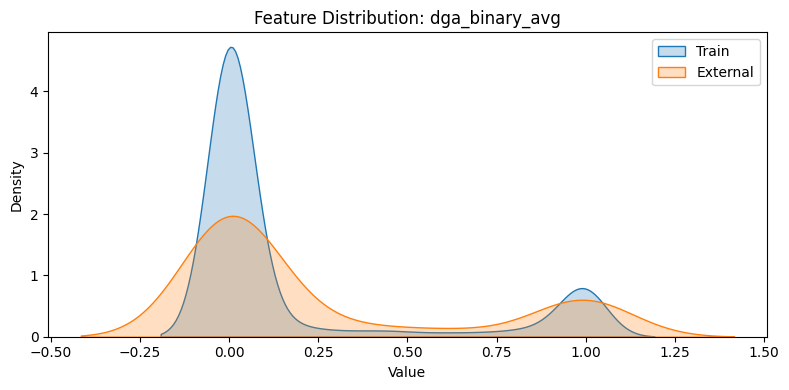

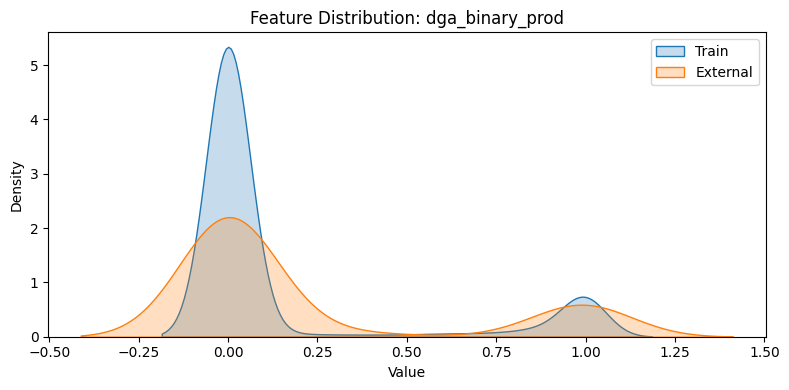

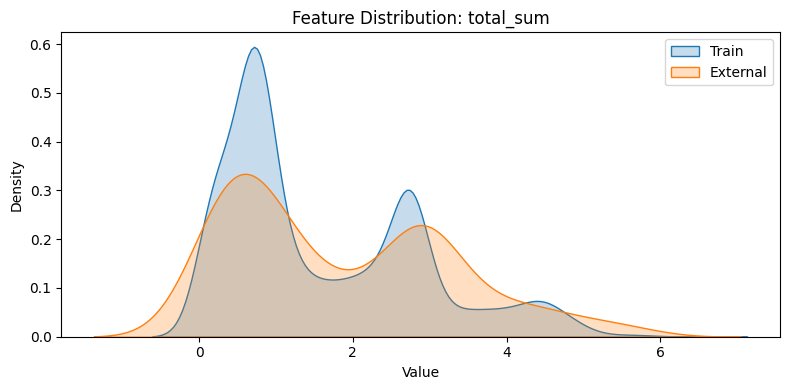

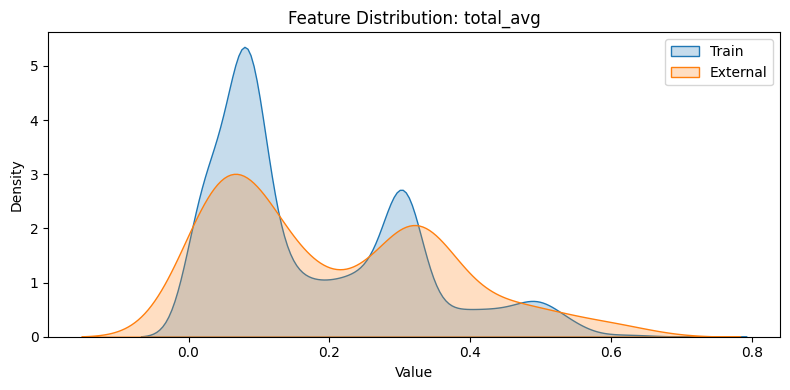

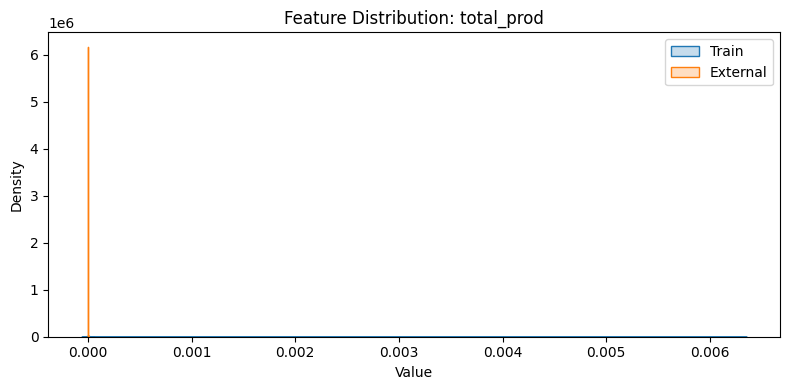

In [32]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
train_df = pd.read_parquet("data/preliminary_results_2504.parquet")
ver_df = pd.read_parquet("data/ver_preliminary.parquet")

# Drop non-feature columns
non_feature_cols = ['label', 'domain_name']
train_features = train_df.drop(columns=non_feature_cols, errors='ignore')
ver_features = ver_df.drop(columns=non_feature_cols, errors='ignore')

# Sample training data (for speed)
train_sample = train_features.sample(n=5000, random_state=42)

# Generate KDE plots
common_features = train_features.columns.intersection(ver_features.columns)

for feature in common_features:
    plt.figure(figsize=(8, 4))
    sns.kdeplot(train_sample[feature], label="Train", fill=True)
    sns.kdeplot(ver_features[feature], label="External", fill=True)
    plt.title(f"Feature Distribution: {feature}")
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.legend()
    plt.tight_layout()
    plt.show()


## Try again the same model on the training dataset (should work if it is not broken)

In [27]:
import pandas as pd
import joblib
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score

# Load the trained model and scaler
model = load_model('models/decision_nn_model.keras')
scaler = joblib.load('boundaries/decision_nn_scaler.joblib')

# Load the parquet file
df = pd.read_parquet('data/preliminary_results_2504.parquet')

# Separate features and labels
X = df.drop(columns=['label', 'domain_name'])
y = df['label']

# Apply the scaler
X_scaled = scaler.transform(X)

# Predict probabilities
probabilities = model.predict(X_scaled)

# Predict classes from probabilities (assuming binary classification)
predictions = (probabilities > 0.5).astype(int).flatten()

# Calculate accuracy
accuracy = accuracy_score(y, predictions)

# Display results
print("Predicted Probabilities:\n", probabilities)
print("\nAccuracy:", accuracy)


18750/18750 [==============================] - 19s 996us/step
Predicted Probabilities:
 [[0.00871231]
 [0.0071167 ]
 [0.00860213]
 ...
 [0.87664855]
 [0.8766649 ]
 [0.8764107 ]]

Accuracy: 0.0


In [33]:
import pandas as pd

# Load data
ver_df = pd.read_parquet("data/ver_preliminary.parquet")

# Check distribution of 'total_prod'
total_prod_counts = ver_df['total_prod'].value_counts().sort_index()
print("Distribution of 'total_prod':")
print(total_prod_counts)

# Count 0.0 vs non-zero
num_zero = (ver_df['total_prod'] == 0.0).sum()
num_nonzero = (ver_df['total_prod'] != 0.0).sum()

print(f"\nNumber of entries where total_prod == 0.0: {num_zero}")
print(f"Number of entries where total_prod != 0.0: {num_nonzero}")


Distribution of 'total_prod':
total_prod
0.000000e+00    8
5.083924e-60    1
2.234798e-53    1
8.204124e-53    1
2.906667e-46    1
               ..
5.825605e-09    1
8.494025e-09    1
2.743699e-08    1
1.847836e-07    1
2.683074e-06    1
Name: count, Length: 203, dtype: int64

Number of entries where total_prod == 0.0: 8
Number of entries where total_prod != 0.0: 202
